In [2]:
import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import welch, stft, butter, lfilter

In [3]:
def get_psd(tod, fs, nspectra, nperseg):
    """
    Chopping time series into pieces and get PSDs
    
    Parameters:
    tod    (1darray): Raw time series
    fs         (int): Sampling frequency of the original data
    nspectra   (int): Number of spectra to get out of the data
    nperseg    (int): Number of points of each segement to average over
                      for each calculated PSD
                      
    Returns:
    ndarray: Frequency bins of spectra
    ndarray: Estimated PSDs
    
    """
    
    npt = tod.size
    nsample = int(npt / nspectra)
    real_size = nspectra * nsample
    
    tod_reshaped = np.reshape(tod[0:real_size], (nspectra, nsample))    
    
    freq, psd = [], []
    for i in range(nspectra):
        f, p = welch(tod_reshaped[i], fs=fs, nperseg=nperseg)
        freq.append(f)
        psd.append(p)
    
    return np.asarray(freq), np.asarray(psd)

In [14]:
def peak_amplitude_stft(tod, fs, nperseg, driving_freq):
    
    ff, tt, Zxx = stft(tod, fs=fs, nperseg=nperseg)
    sig = np.abs(Zxx)
    f = np.where(ff==driving_freq)[0][0]

    # time, peak amplitude^2, sample frequency, sftp
    return tt, sig[f], ff, Zxx[f]

In [ ]:
def charge_from_tt2(signal, drive, centre_freq):
    filt = butter_lowpass_filter(signal, centre_freq+1000, fs = 10**6, order=5)
    filtfilt = butter_highpass_filter(filt, centre_freq-1000, fs = 10**6, order=5)
    
    fftsig = scipy.fft.rfft(filtfilt)
    fftdrive = scipy.fft.rfft(drive)
    corr = fftsig*np.conjugate(fftdrive)
    charge = max(corr, key = abs)
    return charge

In [5]:
def peak_func(x, amp, omega_0, gamma):
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [6]:
params = {'axes.labelsize': 14,
          'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)

## 20230901

In [7]:
drive_freq = 40000

data_file = r"D:\Experiment\Charging\20230901\charging_50s.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

Text(0.5, 1.0, '1 mbar, driving field = 800 mV peak to peak')

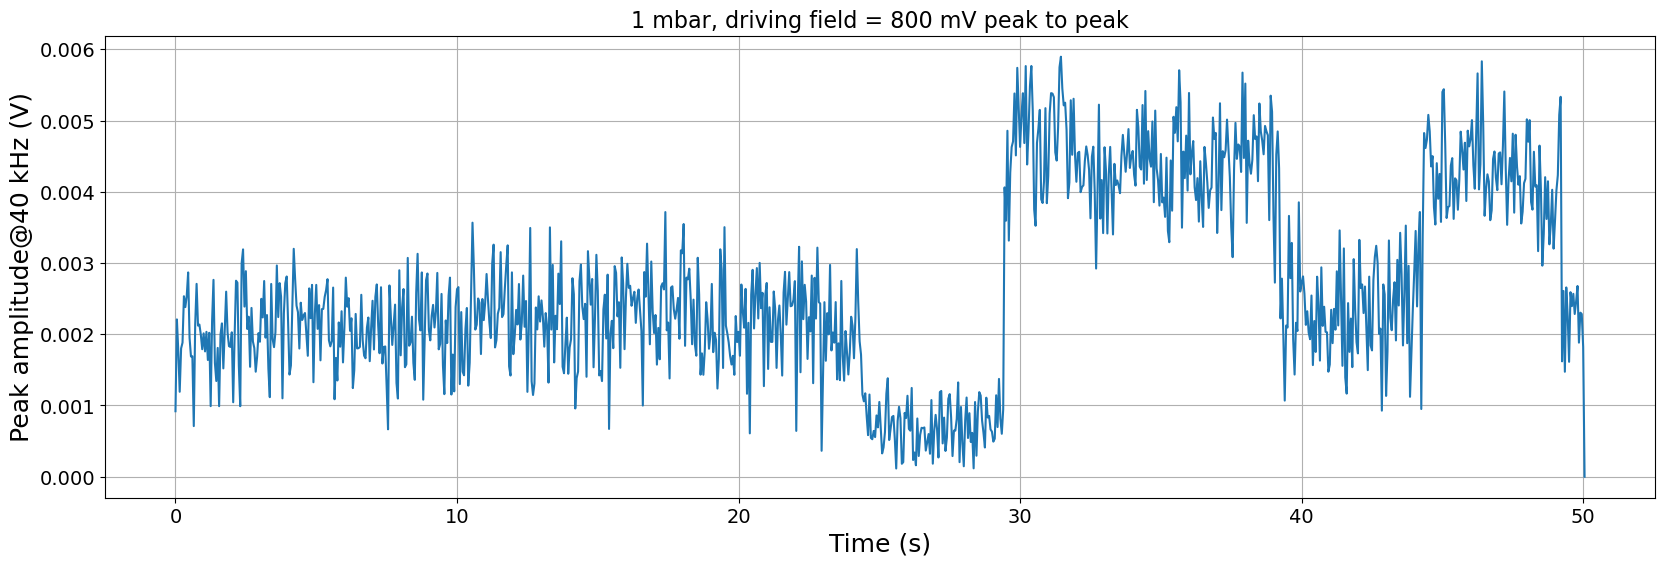

In [22]:
fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
nperseg = fs / 10

tt, sig, ff, Zxx = peak_amplitude_stft(data[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (20, 6))
ax.grid()
ax.plot(tt, sig, '-')

ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Peak amplitude@40 kHz (V)', fontsize=18)
ax.set_title('1 mbar, driving field = 800 mV peak to peak')

In [16]:
drive_freq = 40000

data_file_2 = r"D:\Experiment\Charging\20230901\charging_50s_2.csv"
data_2 = np.genfromtxt(data_file_2, delimiter=',', skip_header=3).T

Text(0.5, 1.0, '1 mbar, driving field = 800 mV peak to peak')

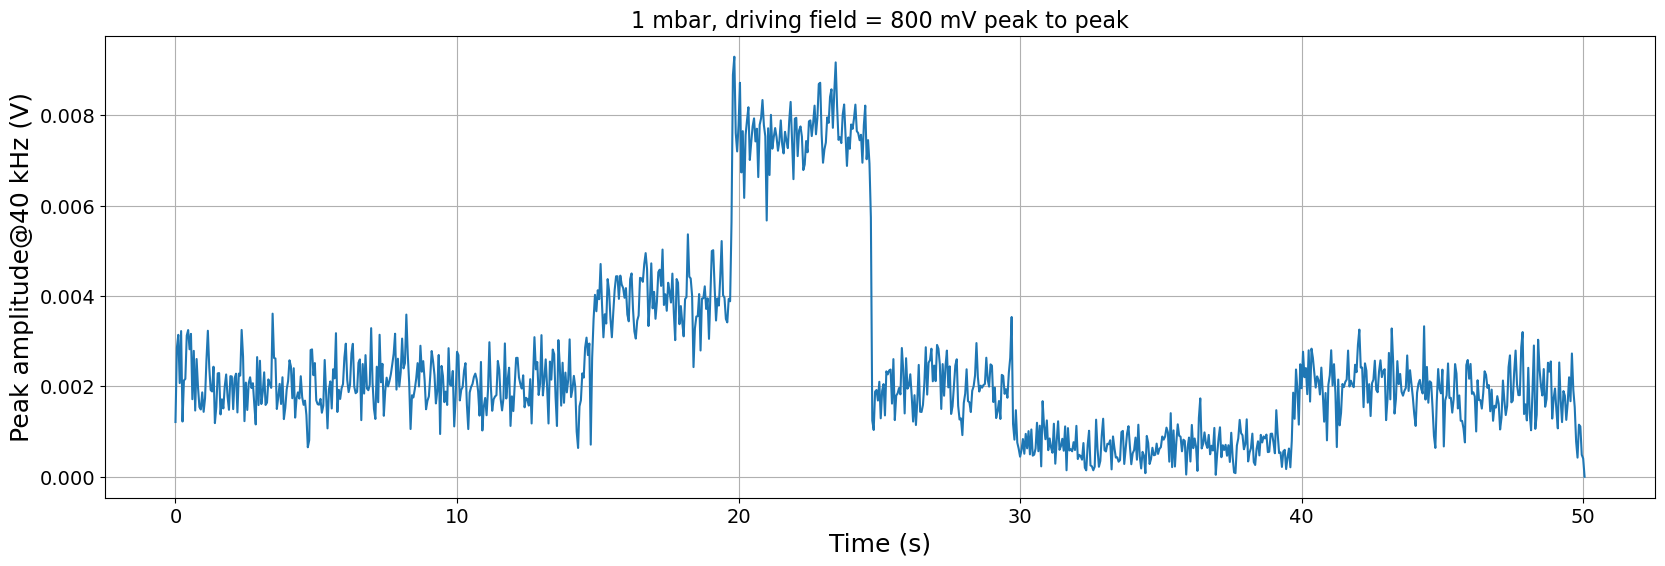

In [21]:
fs = int(np.ceil(1 / (data_2[0, 1] - data_2[0, 0])))
nperseg = fs / 10

tt, sig, ff, Zxx = peak_amplitude_stft(data_2[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (20, 6))
ax.grid()
ax.plot(tt, sig, '-')

ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Peak amplitude@40 kHz (V)', fontsize=18)
ax.set_title('1 mbar, driving field = 800 mV peak to peak')

In [20]:
drive_freq = 40000

nohv_file = r"D:\Experiment\Charging\20230901\nohv_50s.csv"
nohv = np.genfromtxt(nohv_file, delimiter=',', skip_header=3).T

Text(0.5, 1.0, '1 mbar, driving field = 800 mV peak to peak')

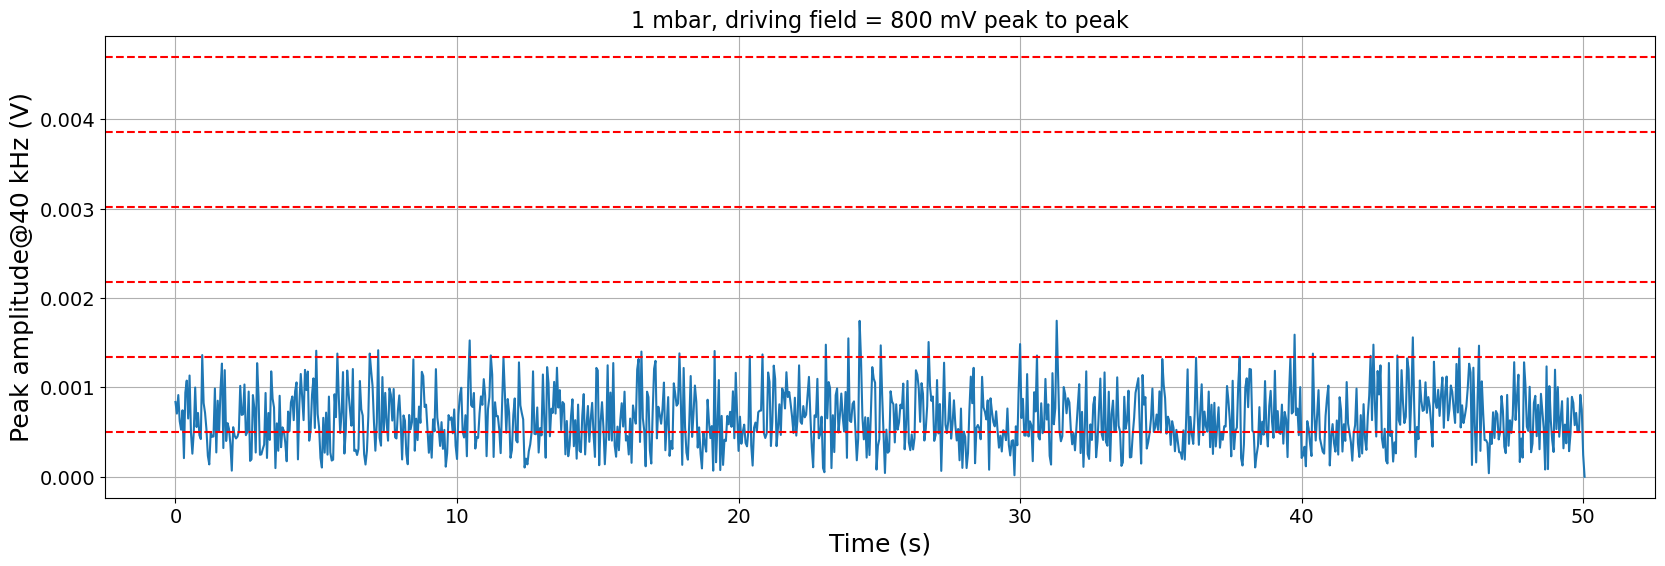

In [22]:
fs = int(np.ceil(1 / (nohv[0, 1] - nohv[0, 0])))
nperseg = fs / 10

tt, sig, ff, Zxx = peak_amplitude_stft(nohv[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (20, 6))
ax.grid()
ax.plot(tt, sig, '-')
# ax.set_ylim(0, 0.01)

for yy in np.linspace(0.0005, 0.0047, 6):
    ax.axhline(y=yy, color='r', linestyle='--')

ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Peak amplitude@40 kHz (V)', fontsize=18)
ax.set_title('1 mbar, driving field = 800 mV peak to peak')

## 20230720
Fit for damping of z and x with PI loop on

In [60]:
loop_on_file = r"D:\Experiment\Precilaser\20230720_loop_off_1_9mbar.csv"
loop_on = np.genfromtxt(loop_on_file, delimiter=',', skip_header=3).T

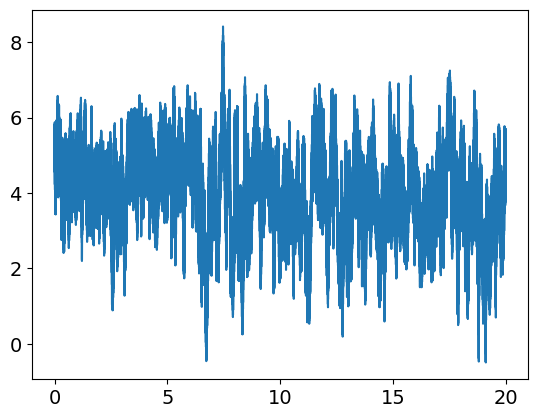

In [82]:
plt.plot(loop_on[0], loop_on[1])

In [69]:
fs = int(np.ceil(1 / (loop_on[0, 1] - loop_on[0, 0])))
nperseg = fs / 10

ff, psd = welch(loop_on[1], fs=fs, nperseg=nperseg)

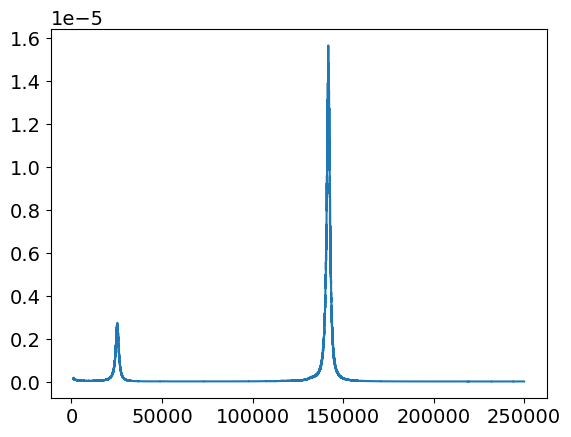

In [83]:
plt.plot(ff[100:], psd[100:])

In [74]:
ff.shape

(25001,)

Fitting to the x peak: Amp=580662314.4490025, Freq=-141872.1586566014, gamma=2024.6541904516635


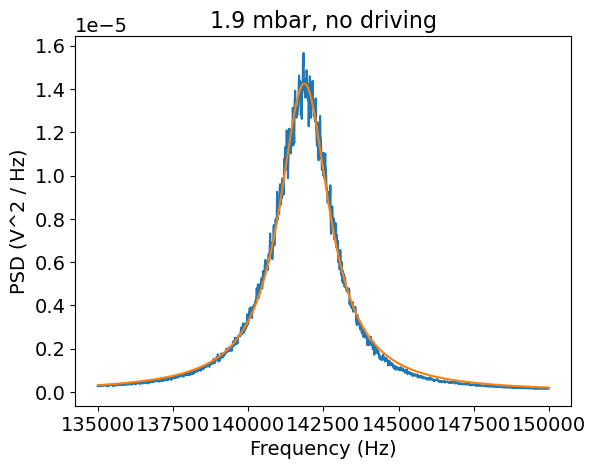

In [88]:
lbx, ubx = 13500, 15000
plt.plot(ff[lbx:ubx], psd[lbx:ubx])
popt, xx, yy = fit_peak(ff[lbx:ubx], psd[lbx:ubx], peak_func, p0=[1e5, 142000, 2000])
plt.plot(xx, yy)

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('PSD (V^2 / Hz)', fontsize=14)
plt.title('1.9 mbar, no driving', fontsize=16)

print(f'Fitting to the x peak: Amp={popt[0]}, Freq={popt[1]}, gamma={popt[2]}')

Fitting to the z peak: Amp=3312909.3850817066, Freq=25326.219935666137, gamma=2022.9457362627813


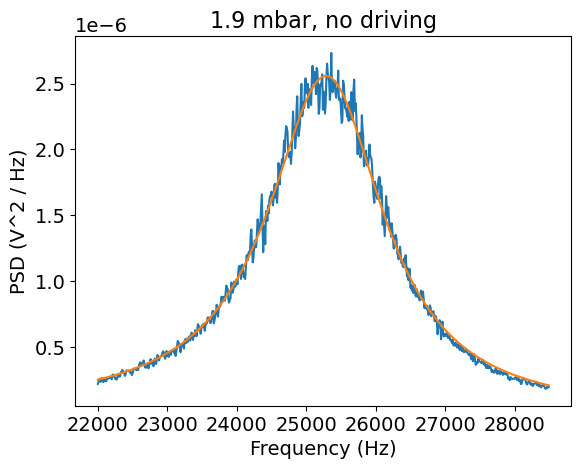

In [95]:
lbz, ubz = 2200, 2850
plt.plot(ff[lbz:ubz], psd[lbz:ubz])
popt, xx, yy = fit_peak(ff[lbz:ubz], psd[lbz:ubz], peak_func, p0=[1e6, 25500, 2000])
plt.plot(xx, yy)

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('PSD (V^2 / Hz)', fontsize=14)
plt.title('1.9 mbar, no driving', fontsize=16)

print(f'Fitting to the z peak: Amp={popt[0]}, Freq={popt[1]}, gamma={popt[2]}')

## 20230719

### Plotting PSD

In [46]:
data_file = r'D:\\Experiment\\Charging\\20230717\\no_force.csv'
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

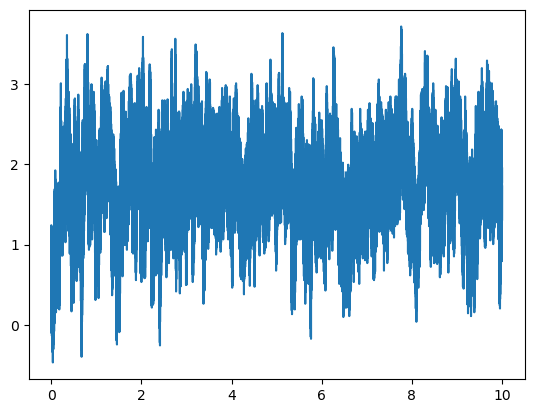

In [47]:
plt.plot(data[0], data[1])

In [49]:
fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
nperseg = data[1].size / 20 / 10

In [50]:
freq, psd = get_psd(data[1], fs, 20, nperseg)

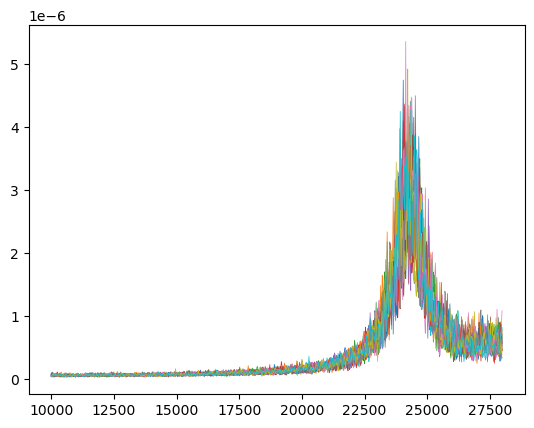

In [59]:
for i, f in enumerate(freq):
    plt.plot(f[500:1400], psd[i][500:1400], linewidth=0.5)
# plt.ylim
# plt.xlim(30e3, 40e3)

### Extract peak amplitude

Try taking longer time traces to figure out the charge states that each amplitude corresonds to

In [8]:
drive_freq = 26000

data_file = r"D:\Experiment\Charging\20230717\charging_1_8mbar_800mV_long.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

Text(0.5, 1.0, '1.8 mbar, driving field = 800 mV peak to peak')

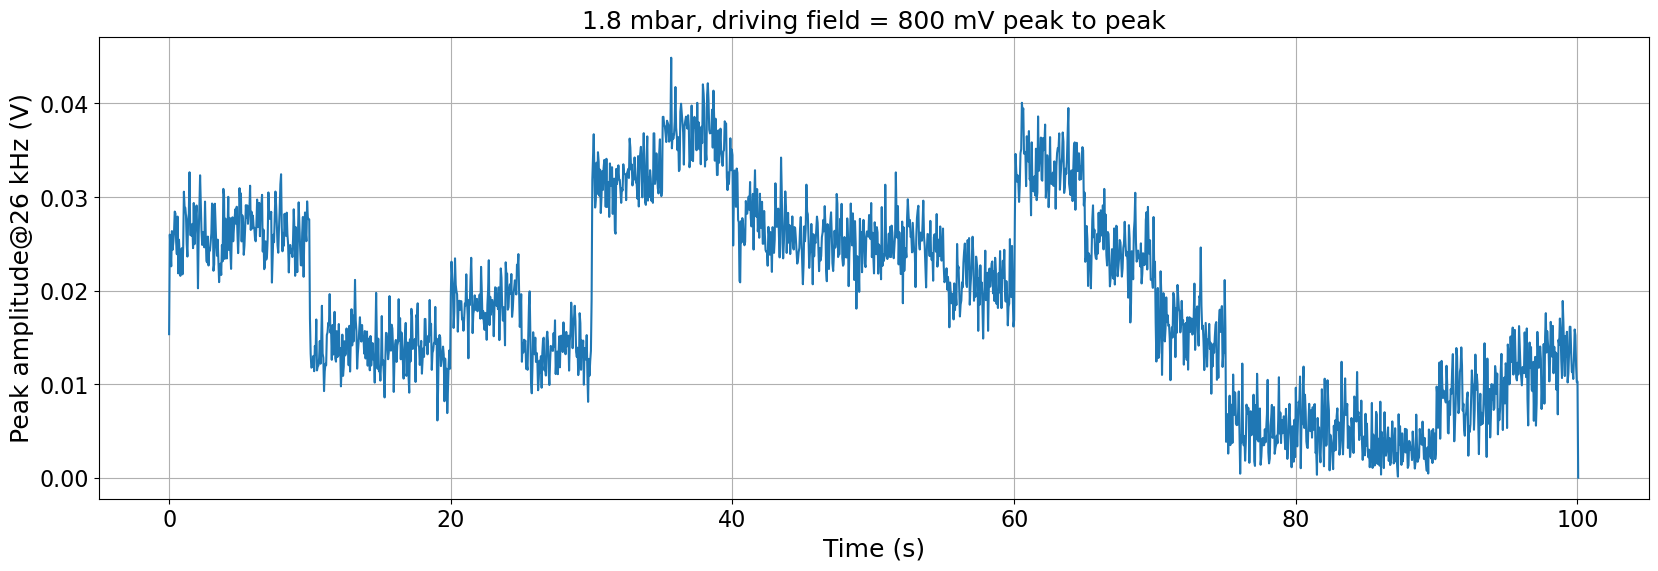

In [14]:
fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
nperseg = fs / 10

tt, sig, ff, Zxx = peak_amplitude_stft(data[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (20, 6))
ax.grid()
ax.plot(tt, sig, '-')

ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Peak amplitude@26 kHz (V)', fontsize=18)
ax.set_title('1.8 mbar, driving field = 800 mV peak to peak')

In [15]:
drive_freq = 26000

data_file = r"D:\Experiment\Charging\20230717\charging_1_8mbar_800mV_long_sec_1.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

Text(0.5, 1.0, '1.8 mbar, driving field = 800 mV peak to peak')

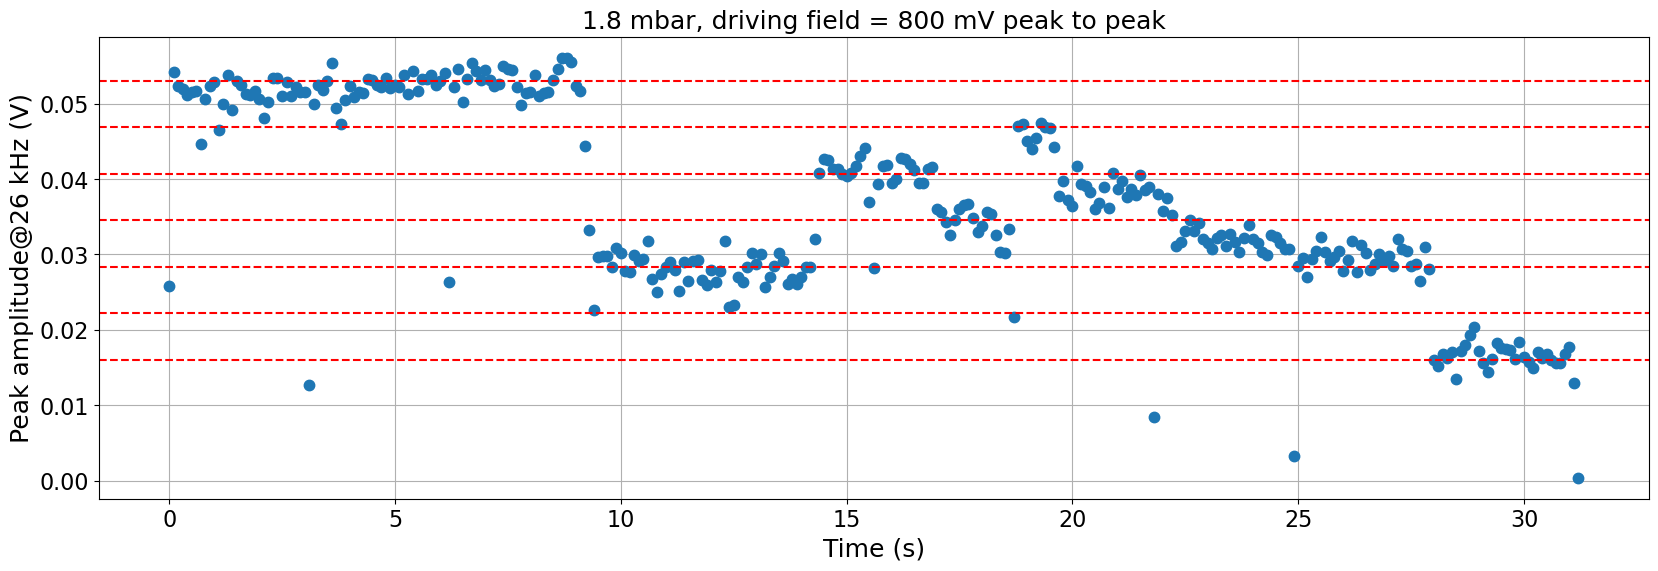

In [18]:
fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
nperseg = fs / 5

tt, sig, ff, Zxx = peak_amplitude_stft(data[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (20, 6))
ax.grid()
ax.plot(tt, sig, '.', markersize=15)

for yy in np.linspace(0.016, 0.053, 7):
    ax.axhline(y=yy, color='r', linestyle='--')

ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Peak amplitude@26 kHz (V)', fontsize=18)
ax.set_title('1.8 mbar, driving field = 800 mV peak to peak')

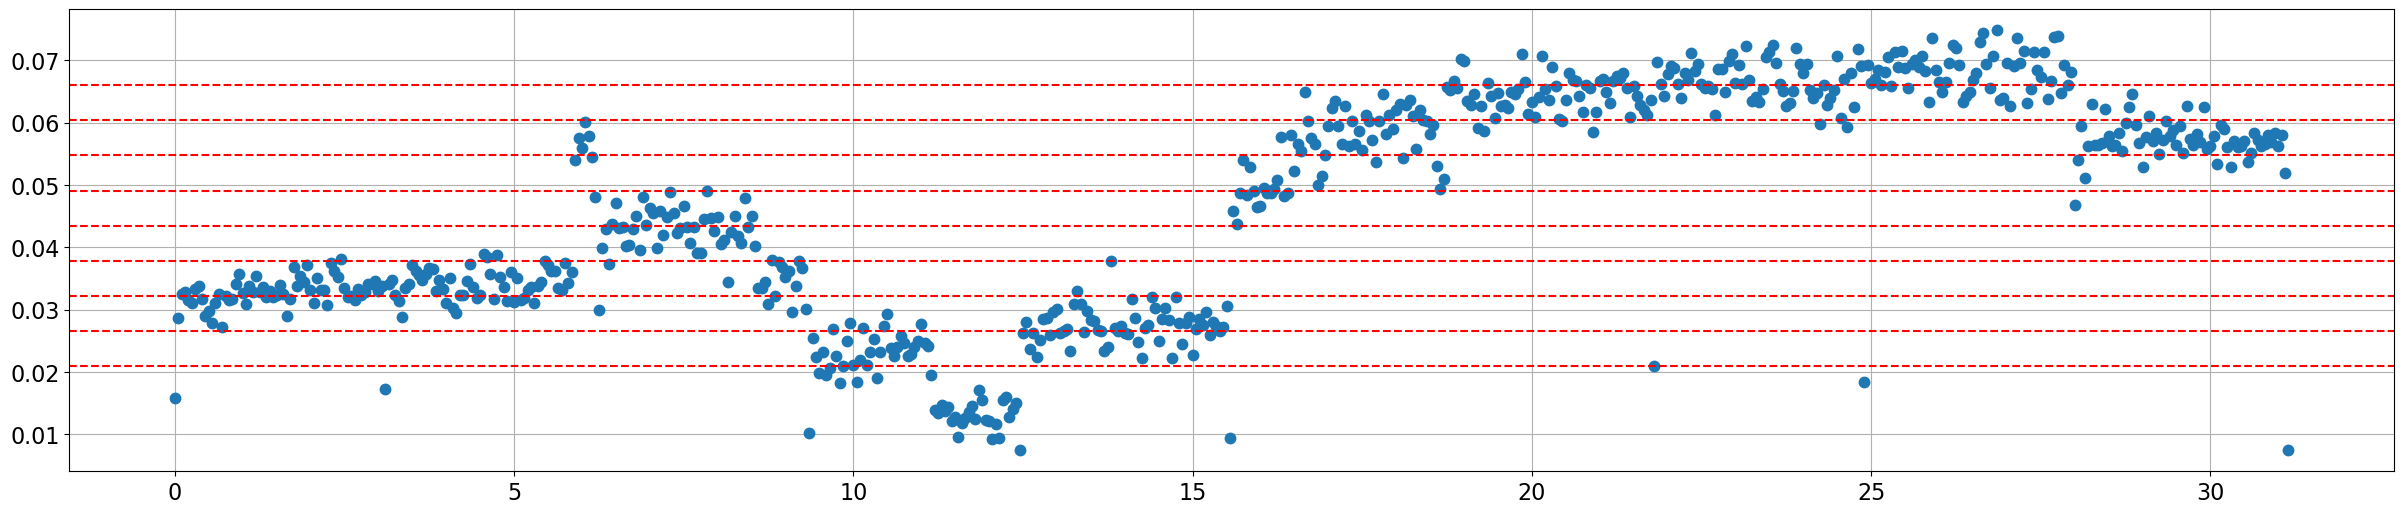

In [20]:
data_file = r"D:\Experiment\Charging\20230717\charging_1_8mbar_800mV_long_sec_2.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
nperseg = fs / 10

tt, sig, ff, Zxx = peak_amplitude_stft(data[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (30, 6))
ax.grid()
ax.plot(tt, sig, '.', markersize=15)

for yy in np.linspace(0.021, 0.066, 9):
    ax.axhline(y=yy, color='r', linestyle='--')

With only 800 mV driving field at 26 kHz, no high voltage. There is slow drift in the amplitude even when there are no charge jumps because the laser power is slowly drifting.

Just by eyeballing each individual charge jump is ~0.005 V in amplitude, so the sphere has approximately 6 charges.

Text(0.5, 1.0, '1.8 mbar, no HV, driving field = 800 mV peak to peak')

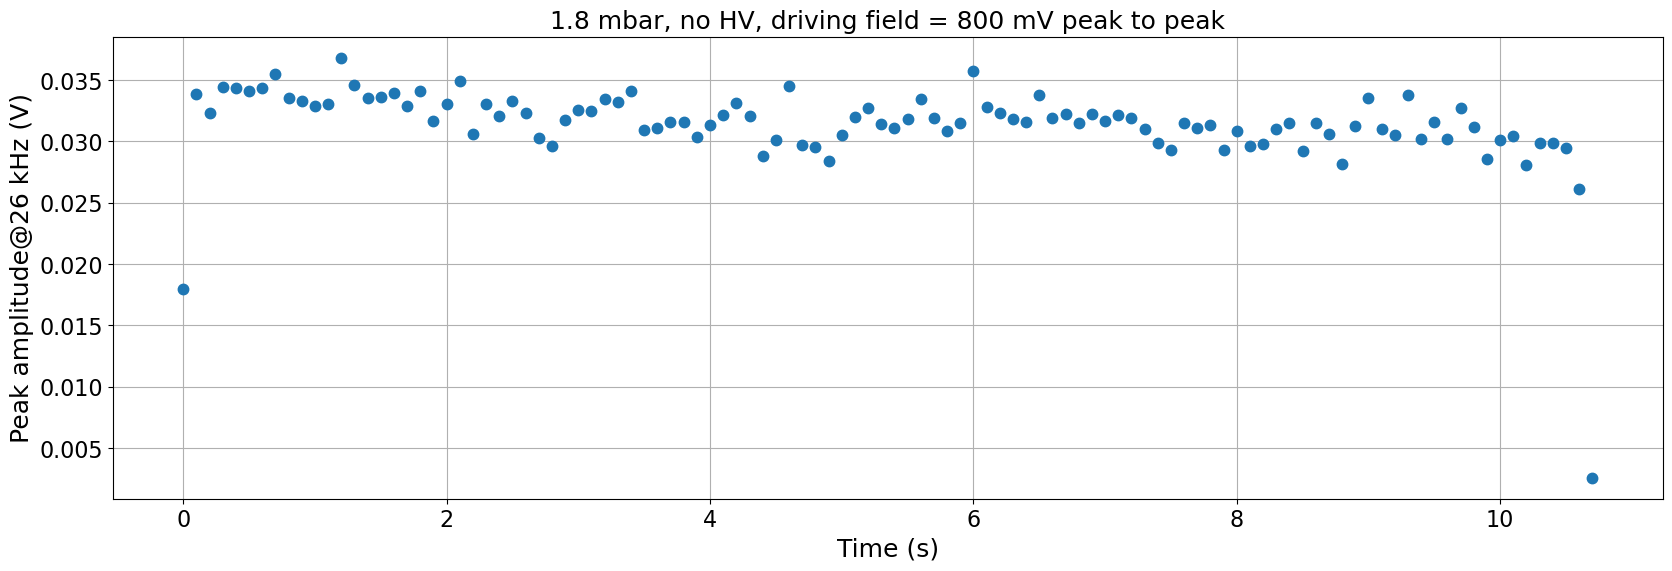

In [55]:
drive_freq = 26000

nohv_file = r"D:\Experiment\Charging\20230717\nohv_1_8mbar_800mV\nohv_1_8mbar_800mV_1.csv"
nohv = np.genfromtxt(nohv_file, delimiter=',', skip_header=3).T

fs = int(np.ceil(1 / (nohv[0, 1] - nohv[0, 0])))
nperseg = fs / 5

tt, sig, ff, Zxx = peak_amplitude_stft(nohv[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (20, 6))
ax.grid()
ax.plot(tt, sig, '.', markersize=15)

ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Peak amplitude@26 kHz (V)', fontsize=18)
ax.set_title('1.8 mbar, no HV, driving field = 800 mV peak to peak')

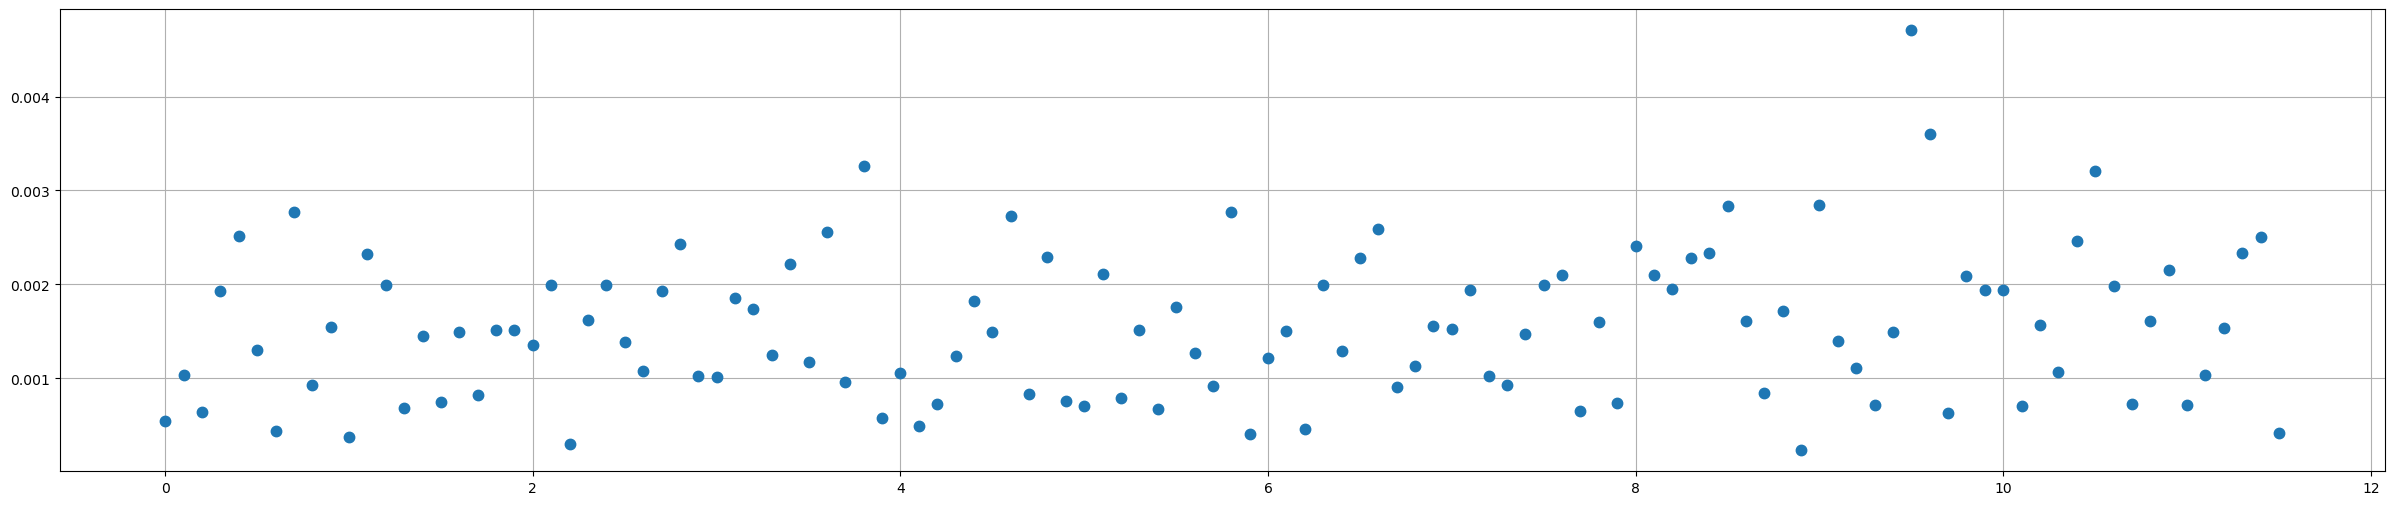

In [7]:
drive_freq = 26000

bg_file = r"D:\Experiment\Charging\20230717\bg_1_9mbar\bg_1_9mbar_3.csv"
bg = np.genfromtxt(bg_file, delimiter=',', skip_header=3).T

fs = int(np.ceil(1 / (bg[0, 1] - bg[0, 0])))
nperseg = fs / 5

tt, sig, ff, Zxx = peak_amplitude_stft(bg[1], fs, nperseg, drive_freq)

fig, ax = plt.subplots(figsize = (30, 6))
ax.grid()
ax.plot(tt, sig, '.', markersize=15)

Fit the z peak to get the center frequency and damping

In [41]:
# We have 100s of data, take only 20s
freq, psd = get_psd(bg[1], fs, 5, fs/10)

Text(0.5, 1.0, '1.8 mbar, no driving')

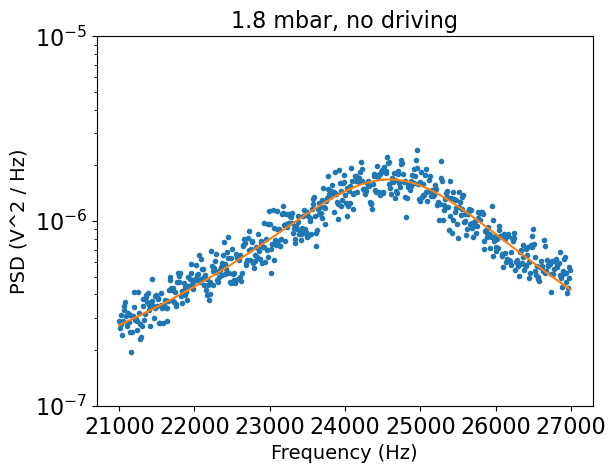

In [52]:
# Take only one of the specturm for analysis
lb, ub = 2100, 2700
plot_idx = 2
plt.plot(freq[plot_idx][lb:ub], psd[plot_idx][lb:ub], '.')

popt, xx, yy = fit_peak(freq[plot_idx][lb:ub], psd[plot_idx][lb:ub], peak_func, p0=[1e6, 24000, 1000])
plt.plot(xx, yy)

plt.yscale('log')
plt.ylim(1e-7, 1e-5)

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('PSD (V^2 / Hz)', fontsize=14)
plt.title('1.8 mbar, no driving', fontsize=16)

In [43]:
# Amplitude, central frequency, damping
print(popt)

[2.98206330e+06 2.46791135e+04 2.93086999e+03]


Integrate over the z peak

In [59]:
np.trapz(psd[plot_idx][lb:ub] * 2 * np.pi, freq[plot_idx][lb:ub]) / 2 * np.pi

0.05418523416897793

Now need to integrate over the driving peak

In [13]:
# Again take 20s of nohv data
freq_nohv, psd_nohv = get_psd(nohv[1], fs, 5, fs/10)

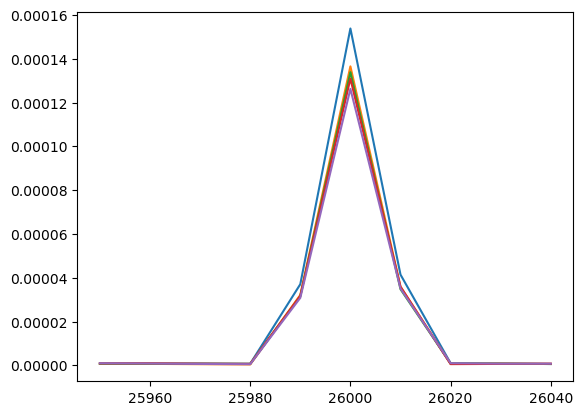

In [14]:
lb, ub = 2595, 2605
for i in range(5):
    plt.plot(freq_nohv[i][lb:ub], psd_nohv[i][lb:ub])

Just pick one and integrate over...

In [15]:
np.trapz(psd_nohv[3][lb:ub], freq_nohv[3][lb:ub])

0.002032630999814068

Calculate the particle mass

In [45]:
f0 = 6 * 1.6e-19 * 2000
omega_z = popt[1] * 2 * np.pi
gamma = popt[2] * 2 * np.pi
omega_d = 26000 * 2 * np.pi
t = 300
kb = 1.38e-23

In [46]:
m = 0.5 * (f0**2 / ((omega_z**2 - omega_d**2)**2 + gamma**2 * omega_d**2)) * 0.00549/0.002 * omega_z**2 / (kb * t)
print(f'The particle mass is {m:.2e} kg')

The particle mass is 1.83e-18 kg


Integrate over both the z peak and the driving peak in the spectrum 

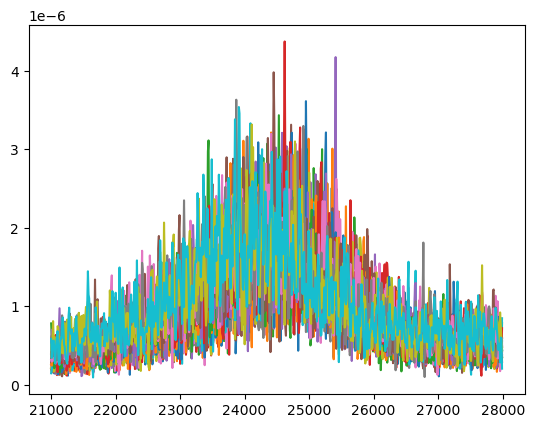

In [163]:


# area = []
for i, pp in enumerate(psd):
    plt.plot(freq[i][lb:ub], pp[lb:ub])
    area.append(np.trapz(pp[lb:ub], freq[i][lb:ub]))

The area under the peak is also drifting -- but let us take it to be 0.005.

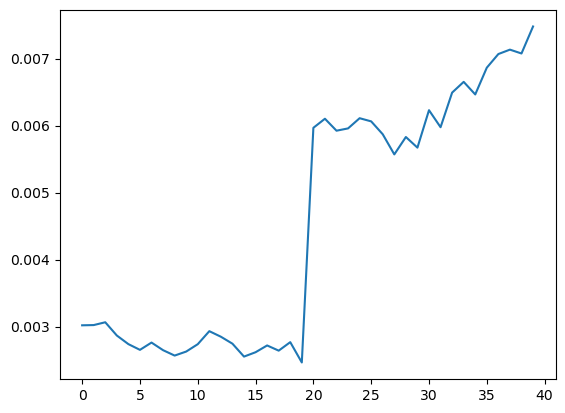

In [164]:
plt.plot(area)

## 2023/05/18

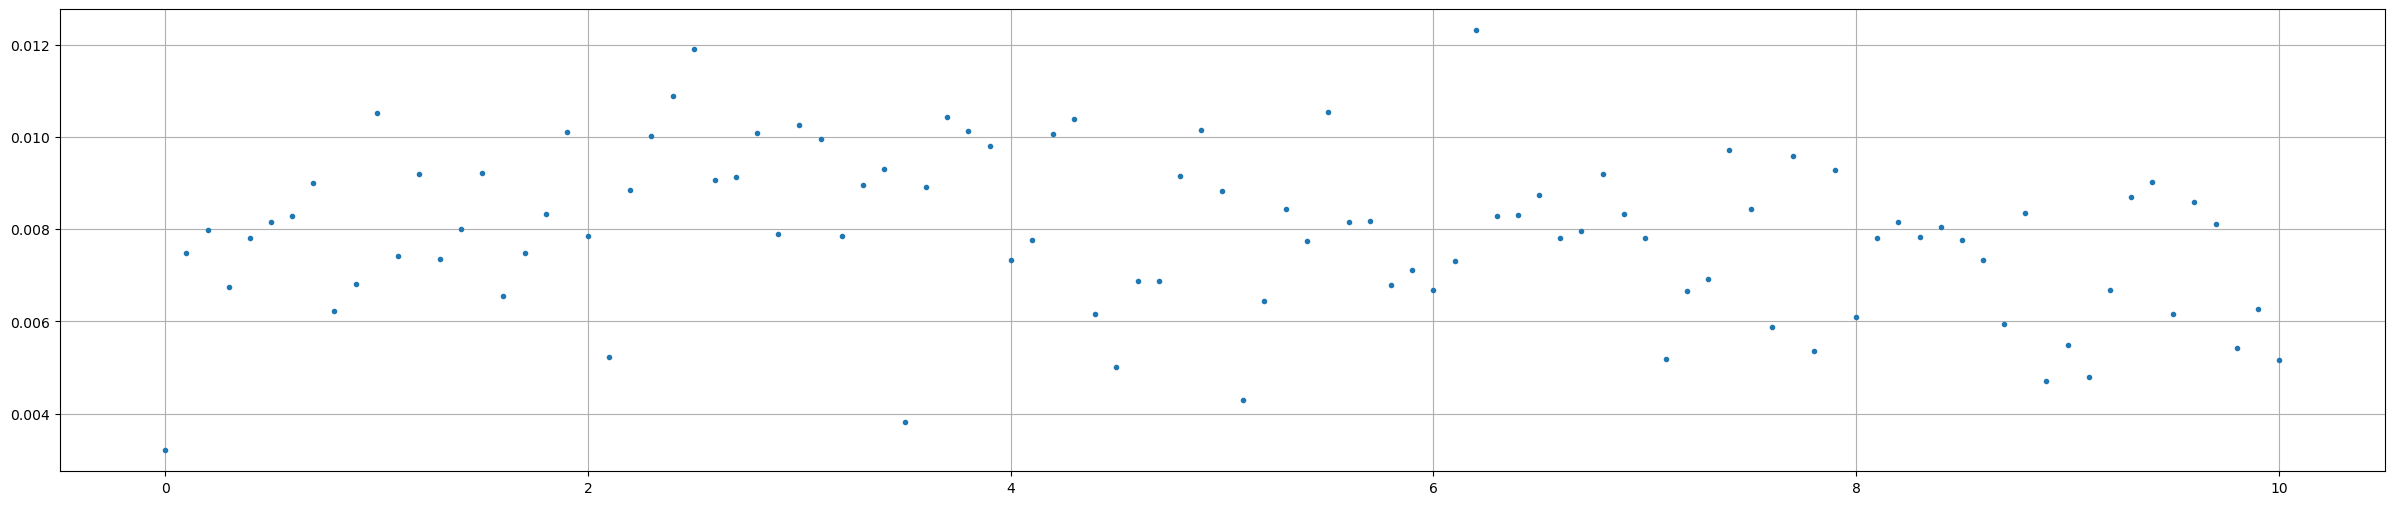

In [36]:
data = sio.loadmat(r'D:\\Experiment\\Charging\\20230518\\charging_10s_2v_24khz.mat')
tod = np.transpose(data['A'])[0]
fs = 1e6 / 10  # Sampling frequency
nperseg = fs / 5

tt, sig, ff, Zxx = peak_amplitude_stft(tod, fs, nperseg, 24000)

plt.figure(figsize = (30, 6))
plt.grid()
plt.plot(tt, sig, '.')

In [51]:
nperseg

20000.0

In [56]:
fff, ppp = get_psd(tod, 100, fs, nperseg)

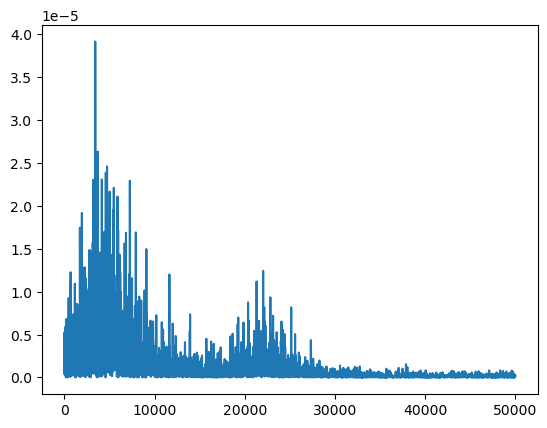

In [58]:
plt.plot(fff[0], ppp[0])

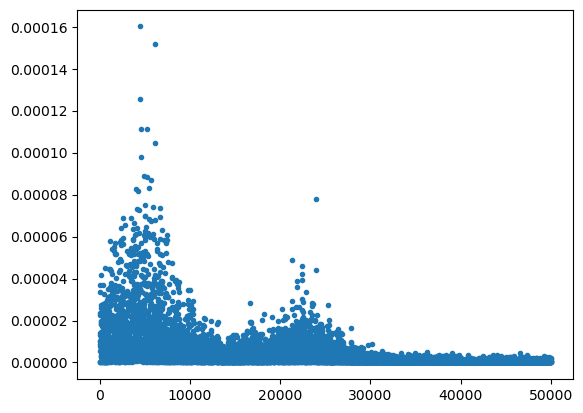

In [47]:
plt.plot( ff, np.abs(Zxx.T[50])**2 , '.')

In [44]:
Zxx.T[10]

array([ 6.1785872e-03+0.j        , -3.6970850e-03-0.00237437j,
        2.3520428e-04+0.00344775j, ...,  5.2513281e-04-0.00015143j,
       -1.9988642e-04+0.0002675j , -8.6502128e-05+0.j        ],
      dtype=complex64)

## Loading data

In [93]:
# data0 = sio.loadmat('D:\\Nanospheres\\Charging\\230413\\charging1.mat')
# data_bg = sio.loadmat('D:\\Nanospheres\\Charging\\230412\\No HV4.mat')
data0 = sio.loadmat('D:\\Nanospheres\\Charging\\230414\\Longer_timetrace\\2V_2.5s.mat')
data_bg = sio.loadmat('D:\\Nanospheres\\Charging\\230414\\charging_3v_10s_nohv_0.mat')

signal0 = np.transpose(data0['A'])[0]
signal1 = np.transpose(data0['B'])[0]
signal_bg = np.transpose(data_bg['A'])[0]
signal_bg_volt = np.transpose(data_bg['B'])[0]

fs = 1e6  # Sampling frequency
# fs = int(50e6 / 200)
nperseg = fs / 1e3 # Number of points for psd calculation

## Quick Estimation

In [81]:
npt = signal0.size
nspectra = 10
nsample = int(npt / nspectra)

tod0 = np.reshape(signal0, (nspectra, nsample))
tod_bg = np.reshape(signal_bg, (nspectra, nsample))

f0, psd0 = get_psd(tod0, fs, nperseg)
f_bg, psd_bg = get_psd(tod_bg, fs, nperseg)

ValueError: cannot reshape array of size 10000000 into shape (10,5000000)

In [21]:
tod.shape

(1000000,)

In [49]:
# This is just a quick and dirty way to get the 32 kHz signal in the spectra
f_sig = np.where(f0[0]==32000)[0][0]
sig0 = psd0.T[f_sig]
sig_bg = psd_bg.T[f_sig]

In [17]:
fs

100000.0

In [13]:
sig.shape

(1000000,)

### Plotting

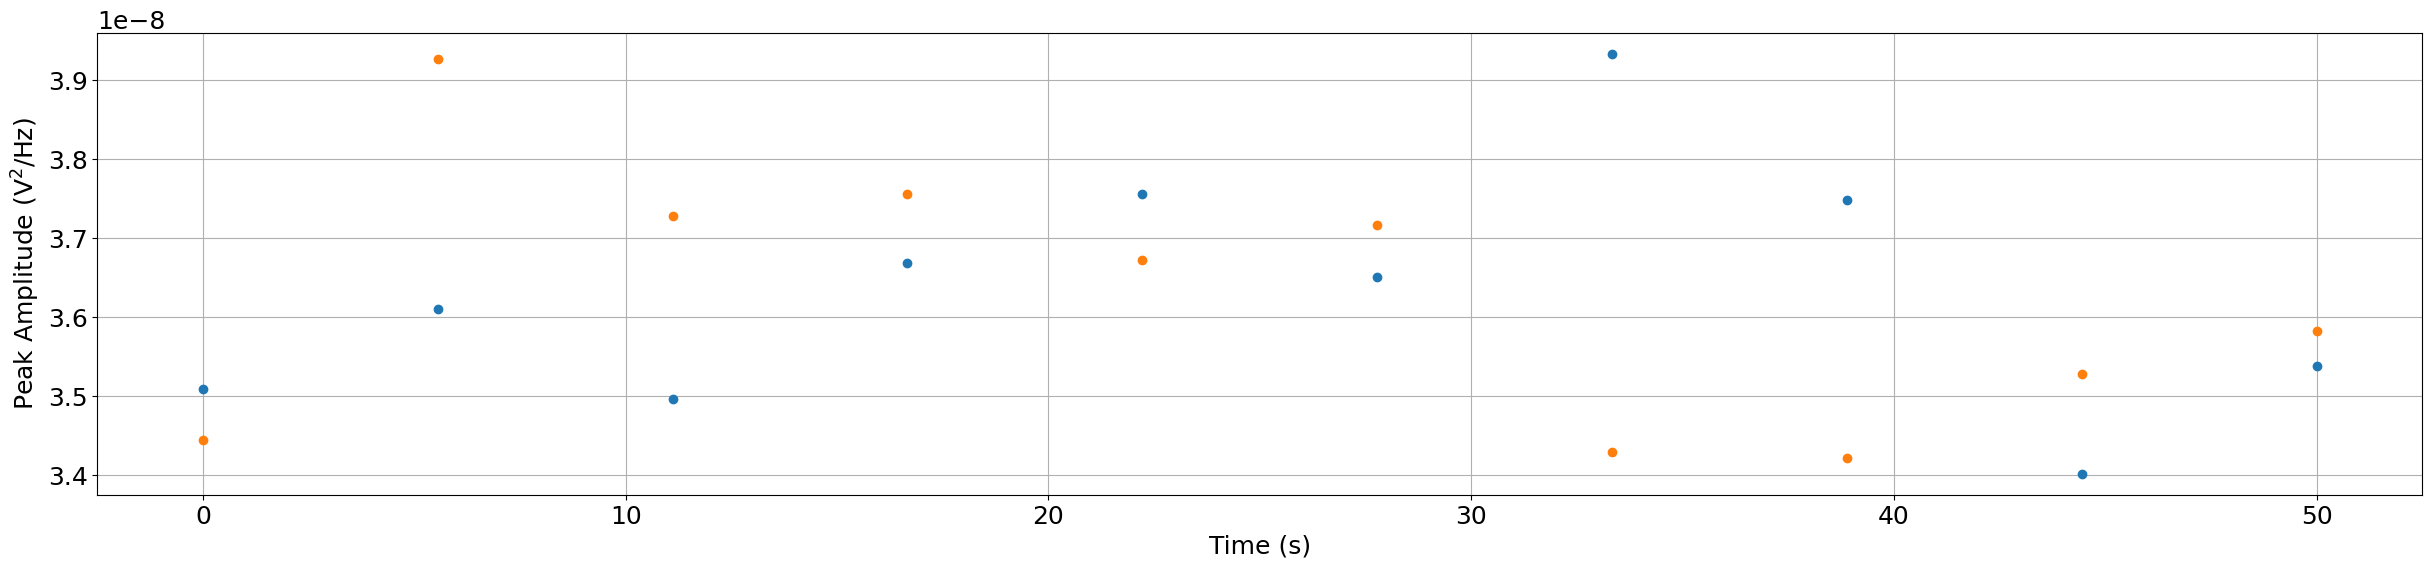

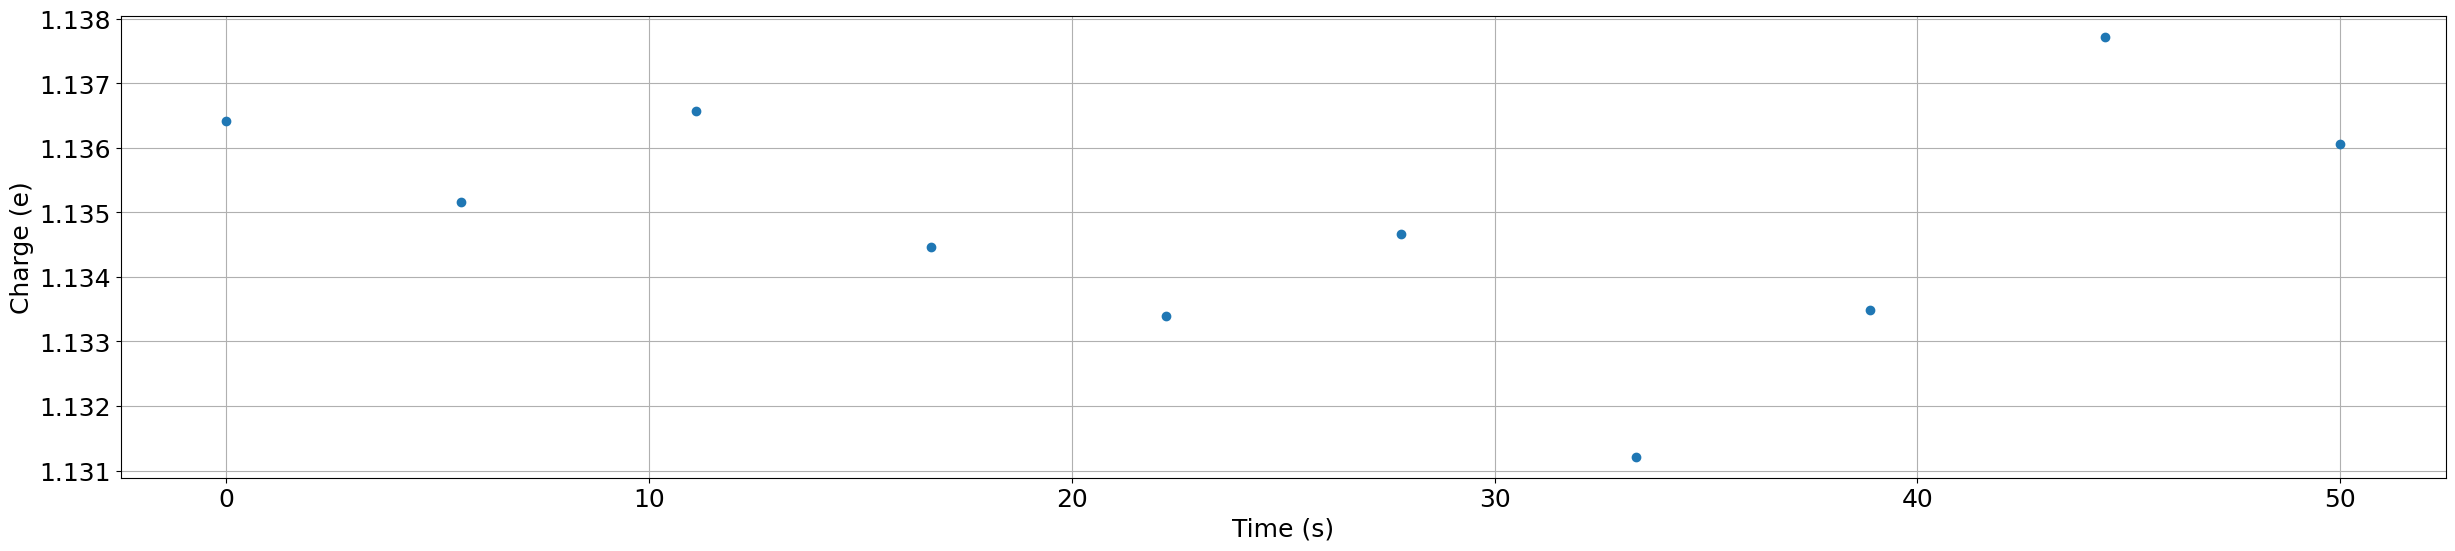

In [25]:
sec = npt / fs
time = np.linspace(0, sec, nspectra)

plt.rc('font', size = 18)
plt.figure(figsize = (30, 6))
plt.grid()
plt.plot(time, np.array(sig0), 'o')
plt.plot(time, np.array(sig_bg), 'o')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
plt.show()

plt.rc('font', size = 18)
plt.figure(figsize = (30, 6))
plt.grid()
plt.plot(time, (np.sqrt(abs(np.array(sig0)- 50*10**(-8))))/(6*10**(-4)), 'o')
plt.ylabel('Charge (e)')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
ff.shape

## Short-time Fourier transfrom

In [85]:
signal0_volt.shape

(20000000,)

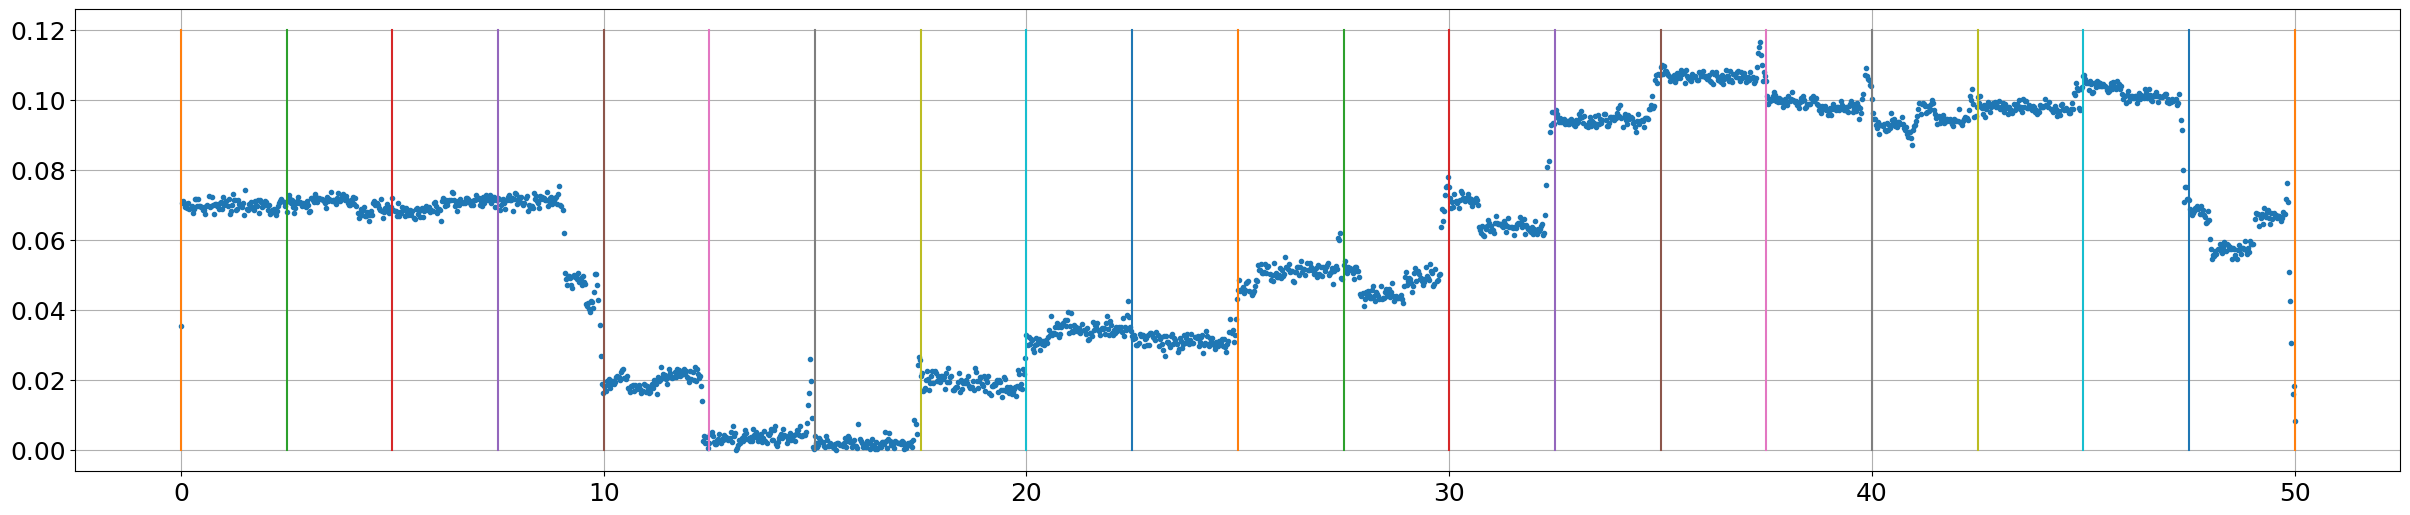

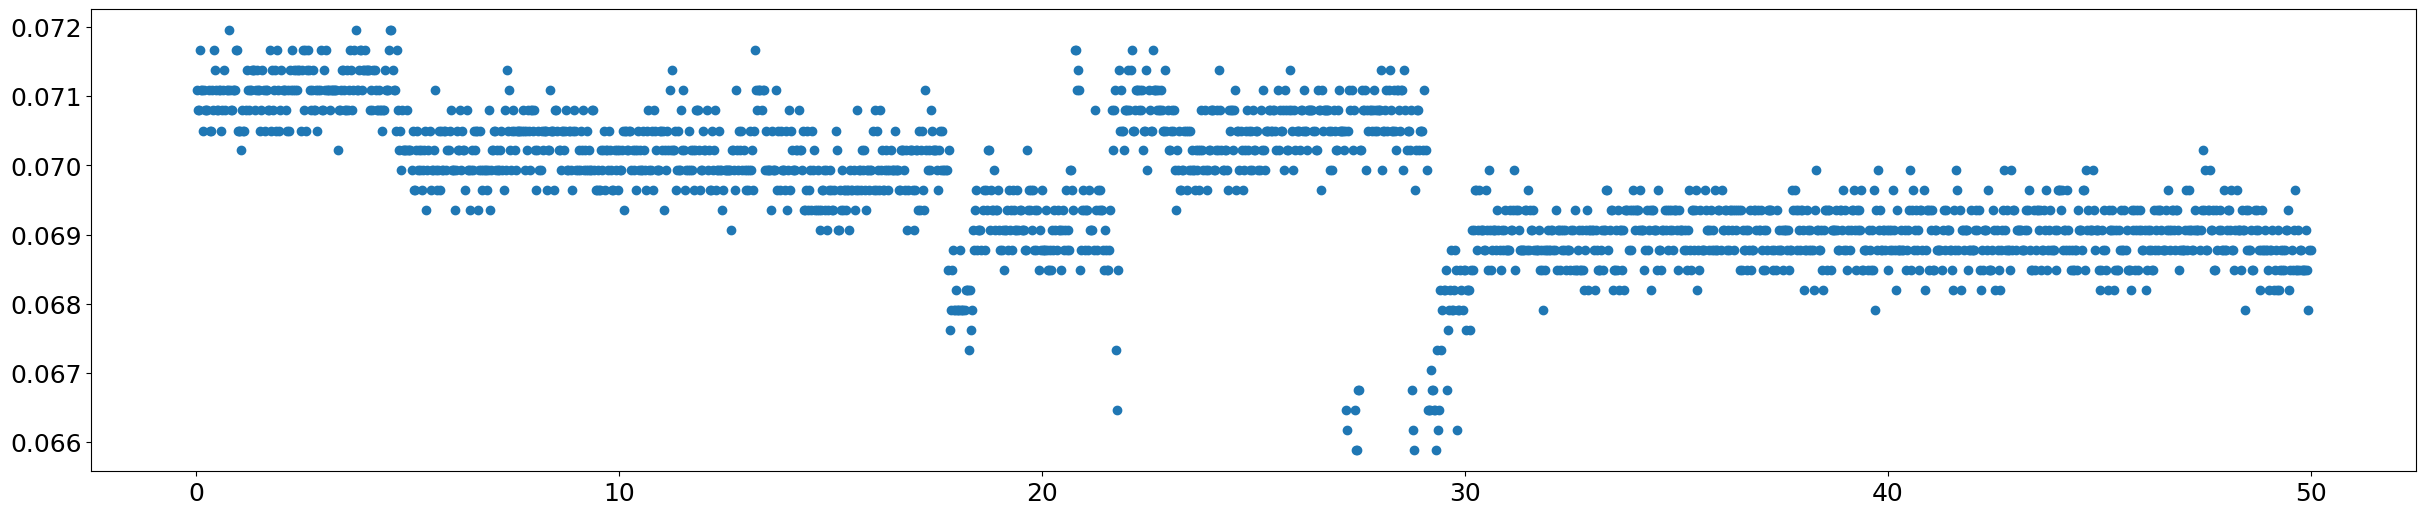

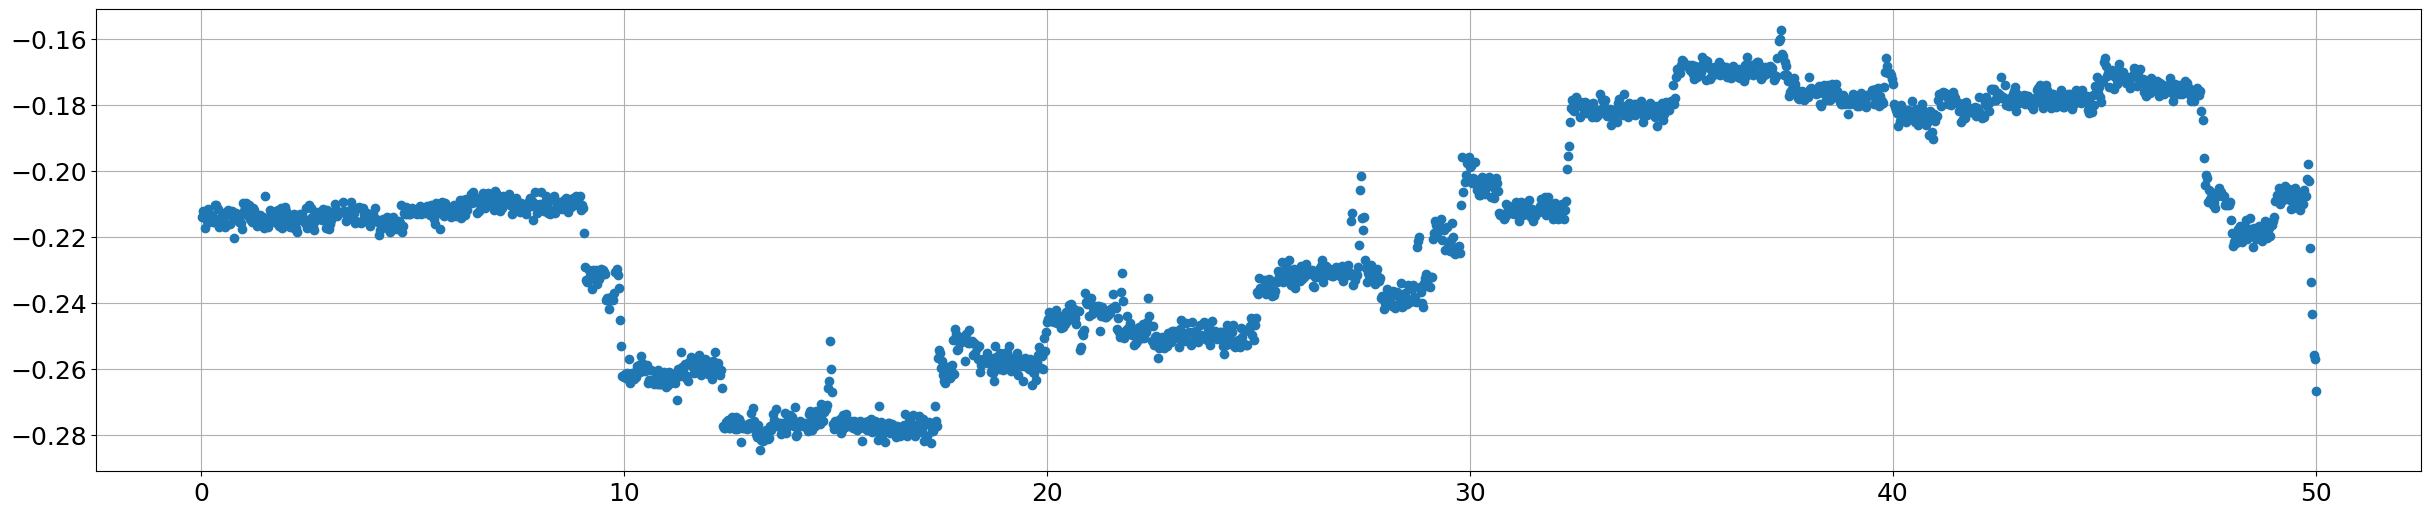

In [92]:
ff, tt, Zxx = stft(signal0, fs=fs, nperseg=nperseg*50)
f = np.where(ff==27000)[0][0]
sig = np.abs(Zxx)

plt.figure(figsize = (30, 6))
plt.grid()
plt.plot(tt, sig[f], '.')
for i in np.arange(0, 51, 2.5):
    plt.plot([i, i],[0.0, 0.12])
    
plt.figure(figsize = (30,6))
plt.plot(tt[1:], signal0_volt[::10000],'o')

plt.figure(figsize = (30, 6))
plt.grid()
plt.plot(tt[1:], sig[f][1:]-4*signal0_volt[::10000], 'o')

[]

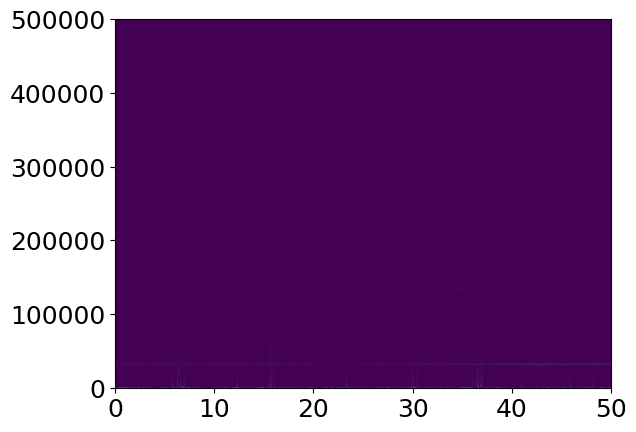

In [117]:
#plt.pcolormesh(tt, ff, sig, shading='nearest')
#plt.plot()

In [80]:
# let's try demod and filter

In [102]:
import scipy 
from scipy.signal import butter, lfilter

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='lowpass')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def charge_from_tt(signal, drive, centre_freq):
    filt = butter_lowpass_filter(signal, centre_freq+1000, fs = 10**6, order=5)
    filtfilt = butter_highpass_filter(filt, centre_freq-1000, fs = 10**6, order=5)
    mod = filtfilt*drive
    mod_filt = butter_lowpass_filter(mod, 10, fs = 10**6, order=2)
    return mod_filt

def charge_from_tt2(signal, drive, centre_freq):
    filt = butter_lowpass_filter(signal, centre_freq+1000, fs = 10**6, order=5)
    filtfilt = butter_highpass_filter(filt, centre_freq-1000, fs = 10**6, order=5)
    fftsig = scipy.fft.rfft(filtfilt)
    fftdrive = scipy.fft.rfft(drive)
    corr = fftsig*np.conjugate(fftdrive)
    charge = max(corr, key = abs)
    return charge

In [103]:
charge1 = charge_from_tt(signal0, signal1, 27000)

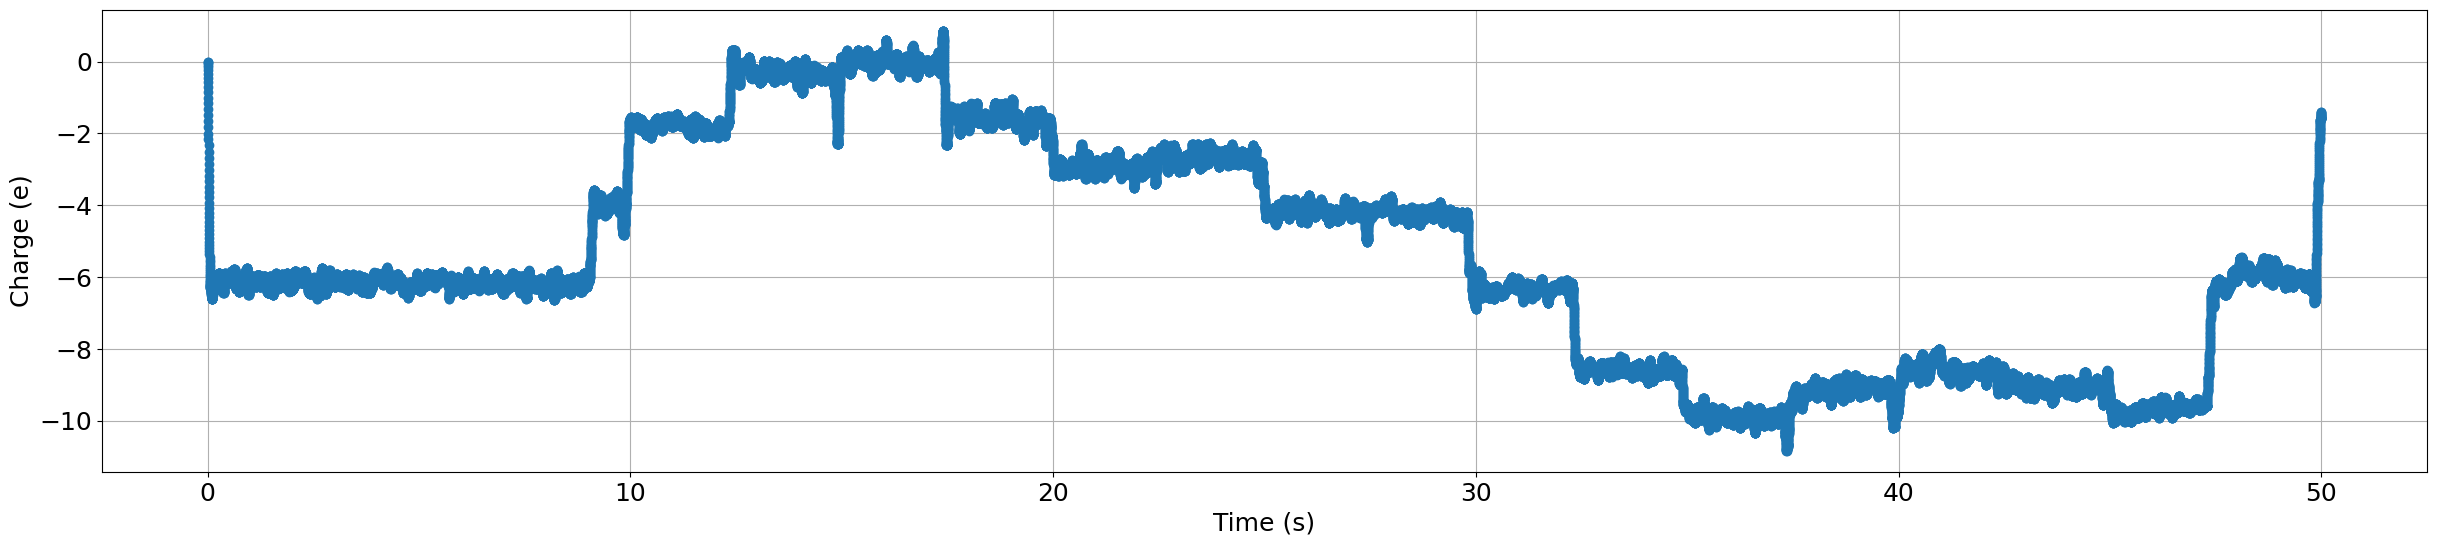

In [109]:
time = np.linspace(0, 50, 50000000)
A = 2.3*10**2

plt.rc('font', size = 18)
plt.figure(figsize = (30, 6))
plt.grid()
plt.plot(time[::1000], A*charge1[::1000], 'o')
#plt.plot([10, 10], [0, 10], '--')
#plt.plot([390, 390], [0, 10], '--')
plt.ylabel('Charge (e)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

In [143]:
events = np.abs(np.diff((np.sqrt(abs(np.array(sig)- 3*10**(-9))))/(7*10**(-5))))

In [232]:
events2 = [0 if i < 0.645 else 1 for i in events]
events3 = [i for i in events if i > 0.645]
print(len(events3))

64


In [248]:
counts = []
tinterval = 5
for i in np.arange(10, 390, tinterval):
    count = events2[i: (i+tinterval)].count(1)
    counts.append(count)

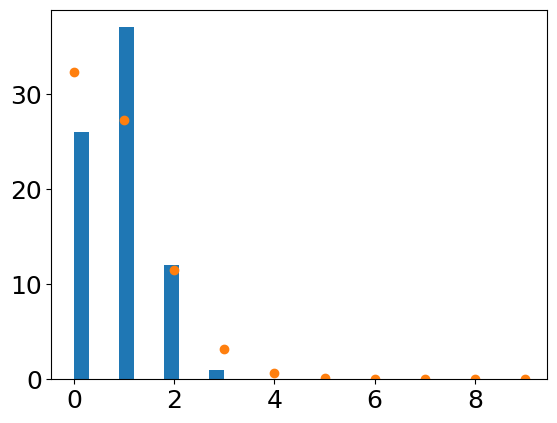

In [255]:
import math

rate = len(events3)/380*tinterval # This is per second. Has to be rate per time interval
k = np.arange(10)
P = rate**k*np.exp(rate)/np.array([math.factorial(j) for j in k])
P = P/sum(P)

plt.hist(counts)
plt.plot(k, P*75, 'o')

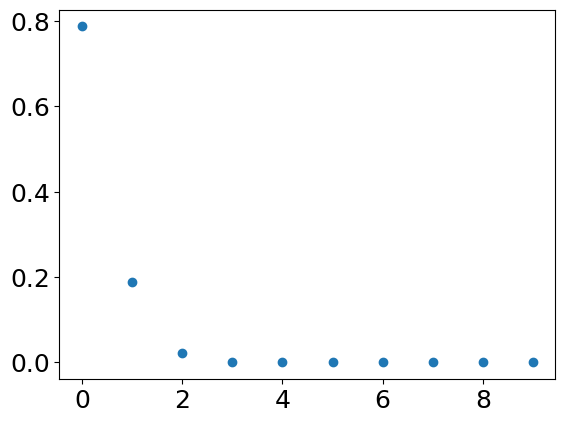

In [79]:
import math

rate = 91/380 # This is per second. Has to be rate per time interval
k = np.arange(10)
P = rate**k*np.exp(rate)/np.array([math.factorial(j) for j in k])
P = P/sum(P)
plt.plot(k, P, 'o')

Text(0.5, 0, 'Frequency (kHz)')

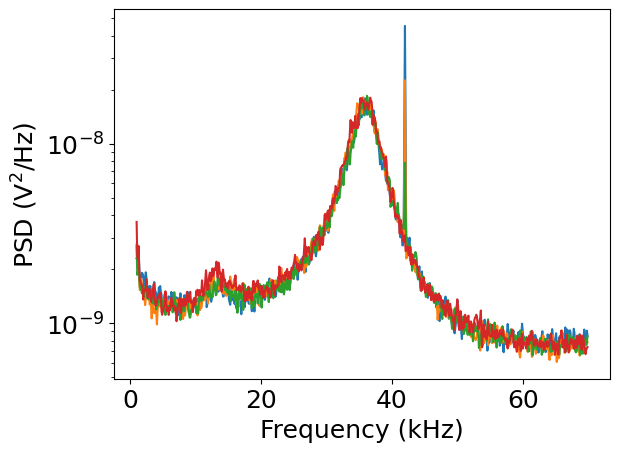

In [33]:
lb = 10
ub = 700
plt.plot(PSDtmp[0][lb:ub]/1000, PSDlist[395][lb:ub])
plt.plot(PSDtmp[0][lb:ub]/1000, PSDlist[278][lb:ub])
plt.plot(PSDtmp[0][lb:ub]/1000, PSDlist[297][lb:ub])
plt.plot(PSDtmp[0][lb:ub]/1000, PSDlist[285][lb:ub])
plt.yscale('log')
plt.ylabel('PSD (V$^2$/Hz)')
plt.xlabel('Frequency (kHz)')

In [ ]:
# So let's fit this data and calibrate by saying it's at 300K then figure out how much a chagre jump would change the height

# Attempt 2

In [16]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 2\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 2\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 2\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 2\\Charging (4).mat')
signal7 = np.transpose(data['B'])[0]
signal8 = np.transpose(data['D'])[0]

In [17]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal7[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

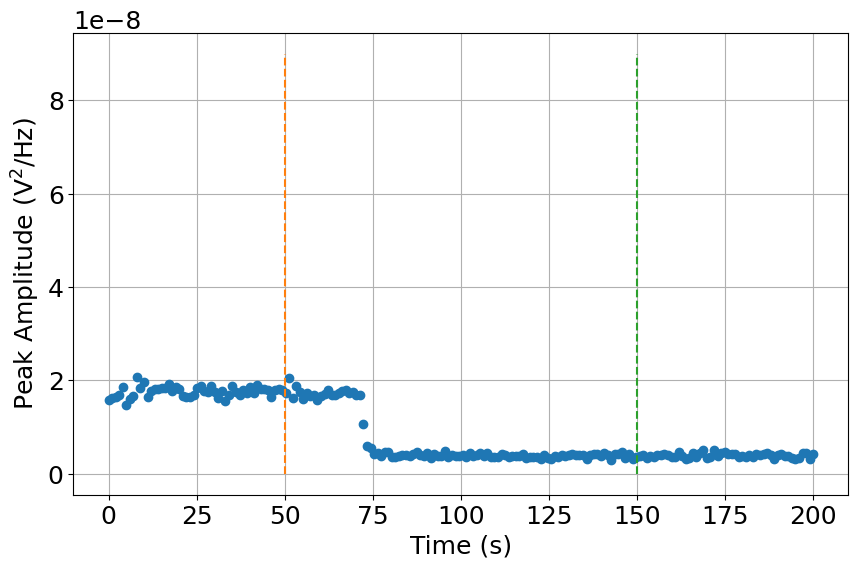

In [18]:
time = np.linspace(0, 200, 200)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([50, 50], [0, 9*10**(-8)], '--')
plt.plot([150, 150], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 3

In [61]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 3\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 3\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 3\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 3\\Charging (4).mat')
signal7 = np.transpose(data['B'])[0]
signal8 = np.transpose(data['D'])[0]

In [62]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal7[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

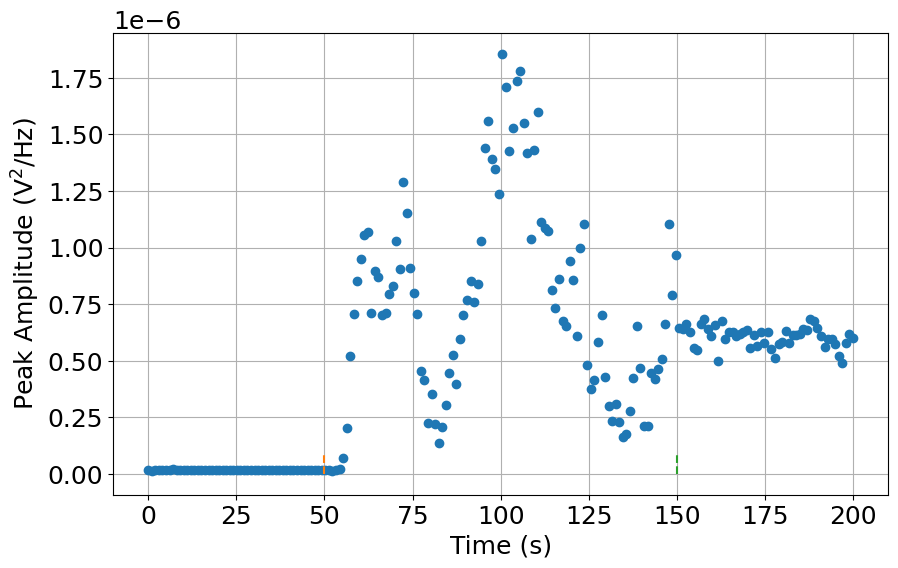

In [65]:
time = np.linspace(0, 200, 200)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([50, 50], [0, 9*10**(-8)], '--')
plt.plot([150, 150], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 5*10**(-8))
plt.show()

# Attempt 4

In [37]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 4\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 4\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 4\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

In [38]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

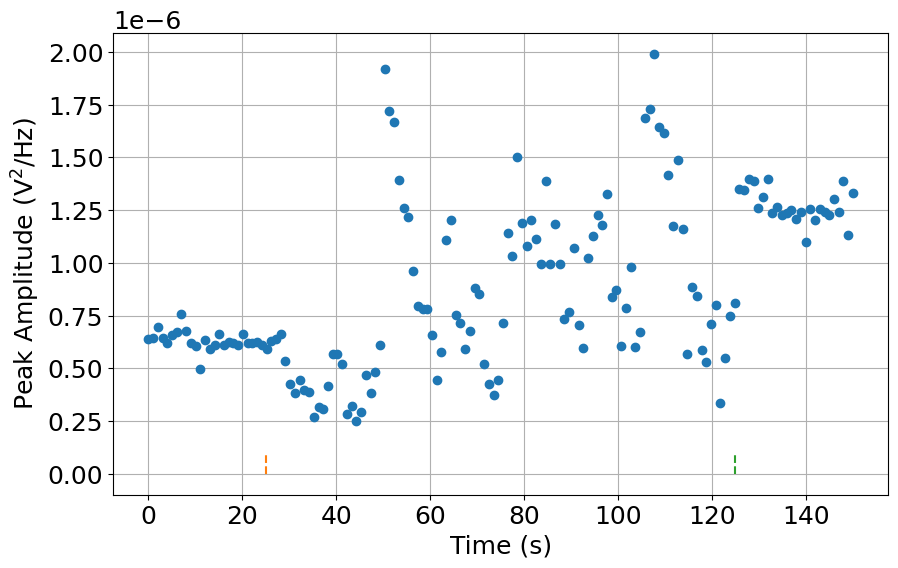

In [39]:
time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([25, 25], [0, 9*10**(-8)], '--')
plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 5

In [34]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 5\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 5\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 5\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

In [35]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

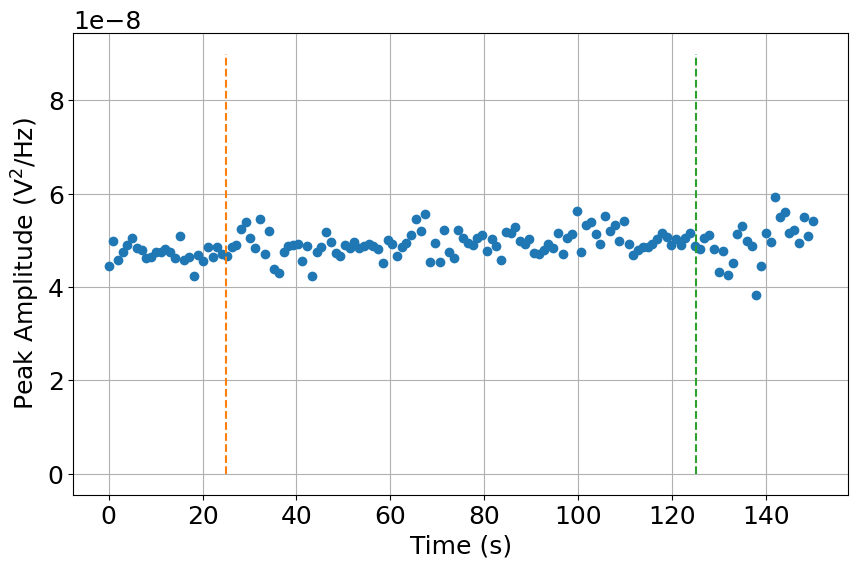

In [36]:
time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([25, 25], [0, 9*10**(-8)], '--')
plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 6

In [40]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 6\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 6\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 6\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

In [41]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

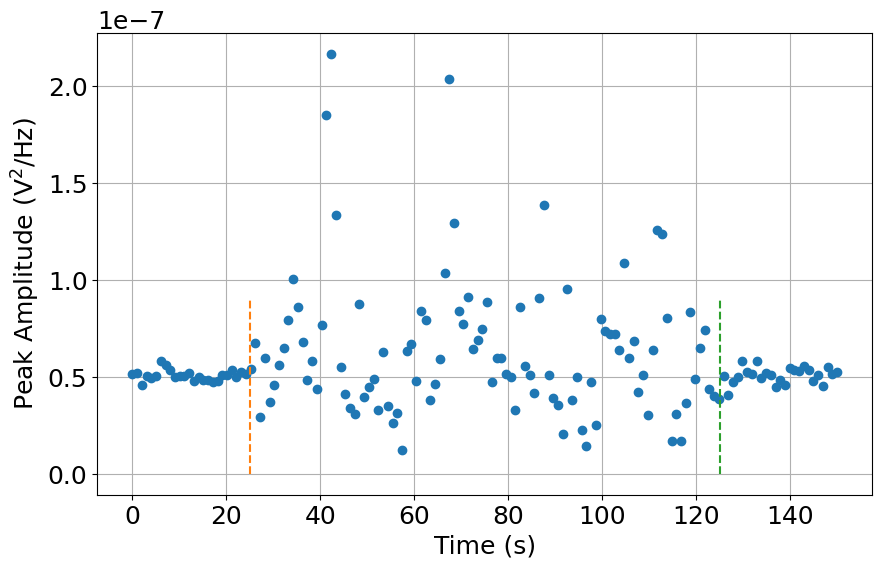

In [42]:
time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([25, 25], [0, 9*10**(-8)], '--')
plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 7

In [43]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 7\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 7\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 7\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

In [44]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

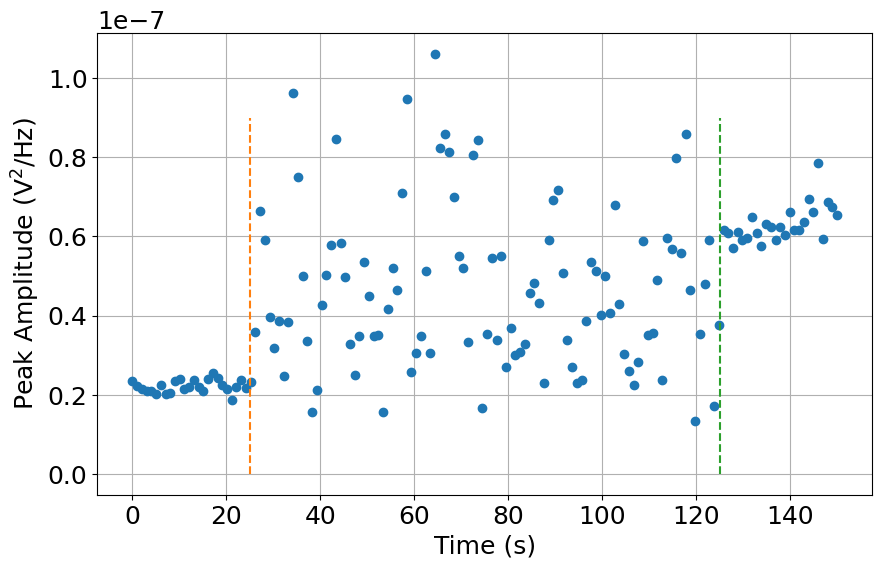

In [45]:
time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([25, 25], [0, 9*10**(-8)], '--')
plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 8

In [47]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 8\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 8\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 8\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

In [48]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

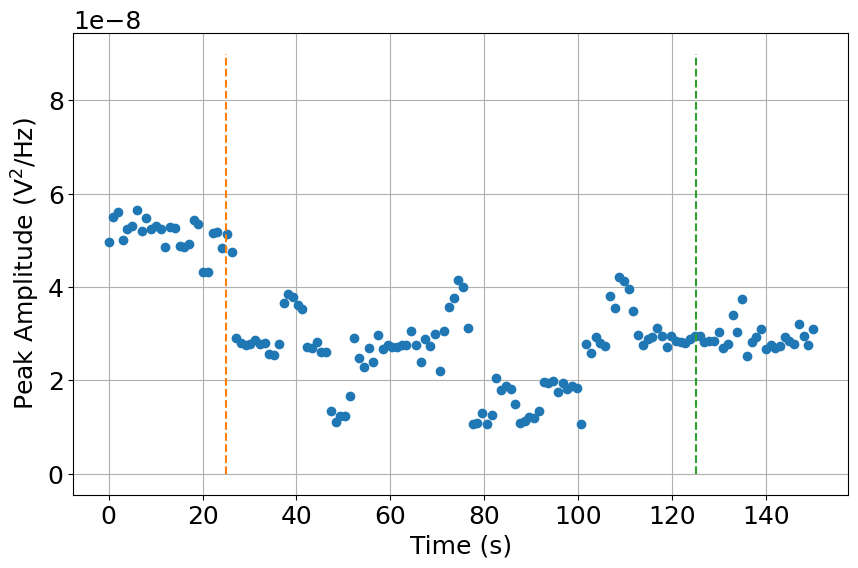

In [49]:
time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([25, 25], [0, 9*10**(-8)], '--')
plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 9

In [51]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 9\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 9\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 9\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

In [52]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

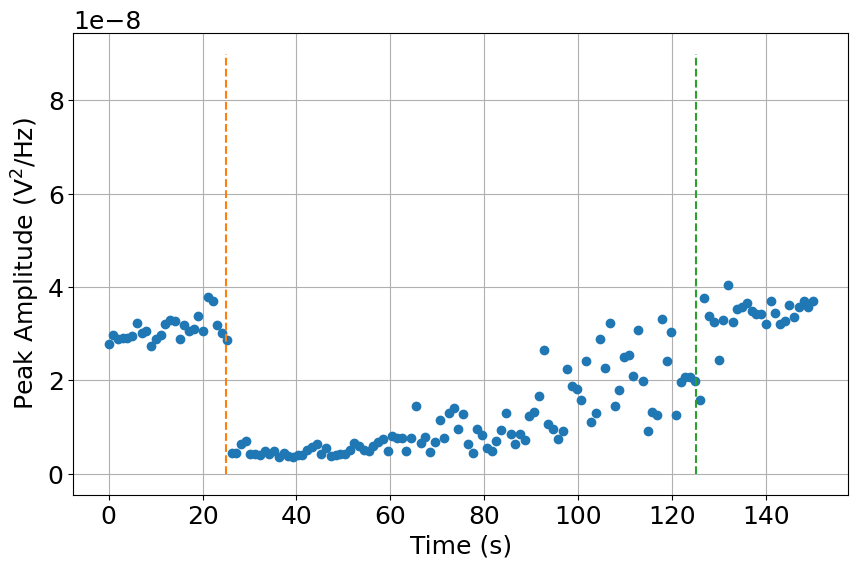

In [53]:
time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([25, 25], [0, 9*10**(-8)], '--')
plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 10

In [54]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 10\\Charging.mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

In [55]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

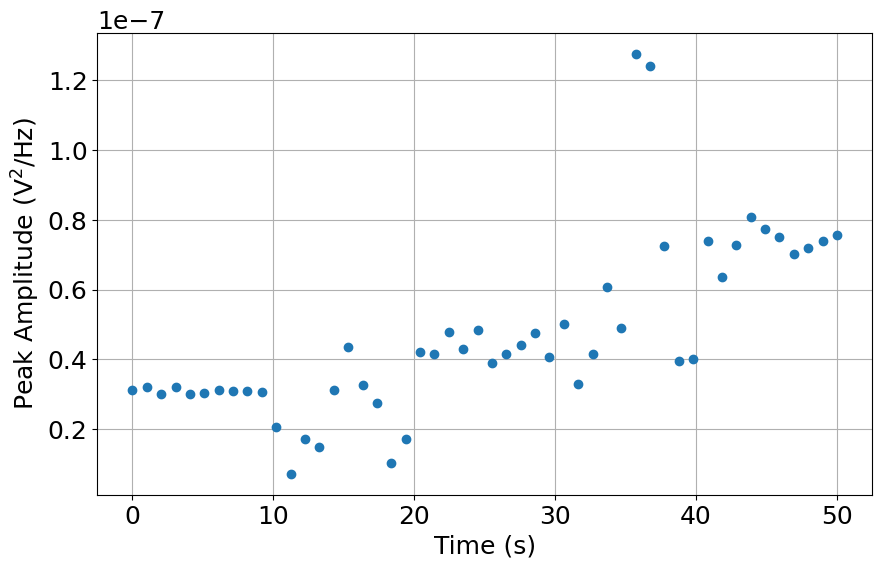

In [56]:
time = np.linspace(0, 50, 50)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 11

In [121]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 11\\Charging.mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

In [122]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

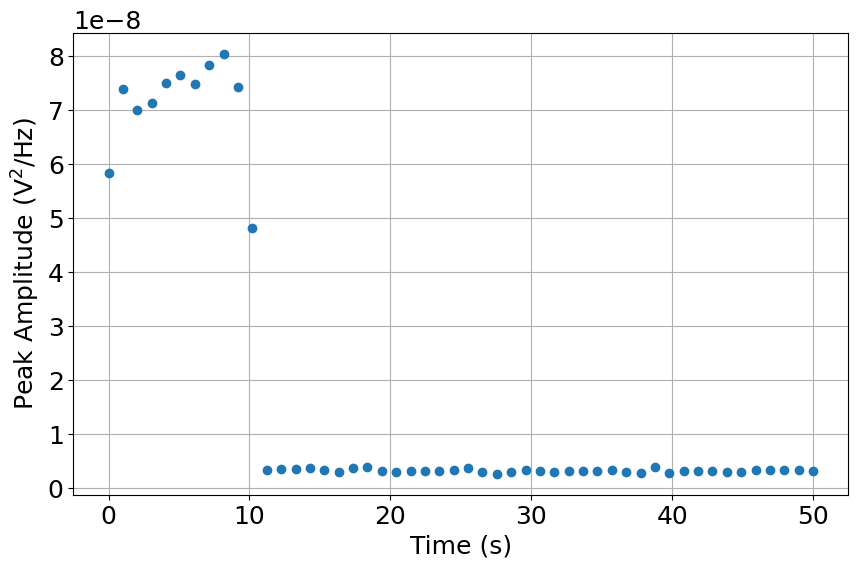

In [60]:
time = np.linspace(0, 50, 50)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.fill_between([10, 40], [0, 0], [8*10])
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 12

In [108]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 12\\Charging.mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

In [109]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*1*10**6:(i+1)*1*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

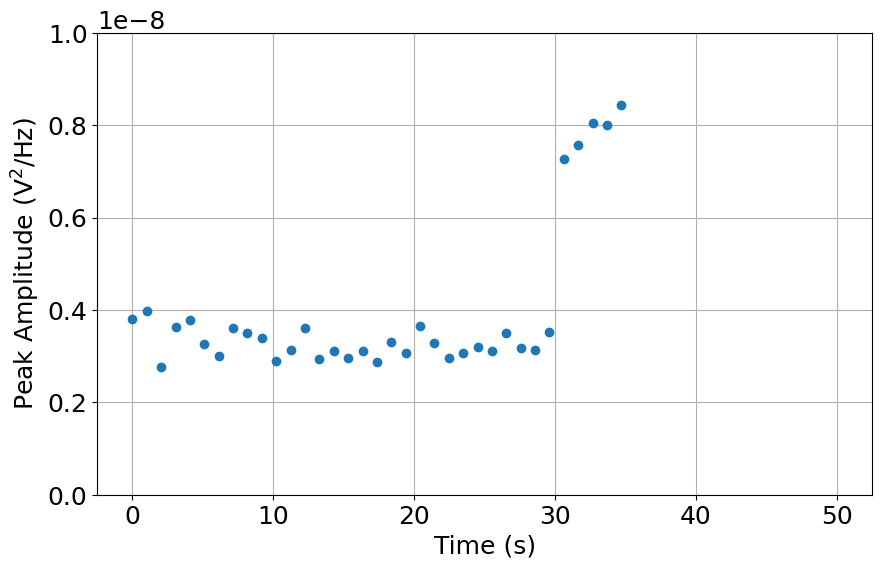

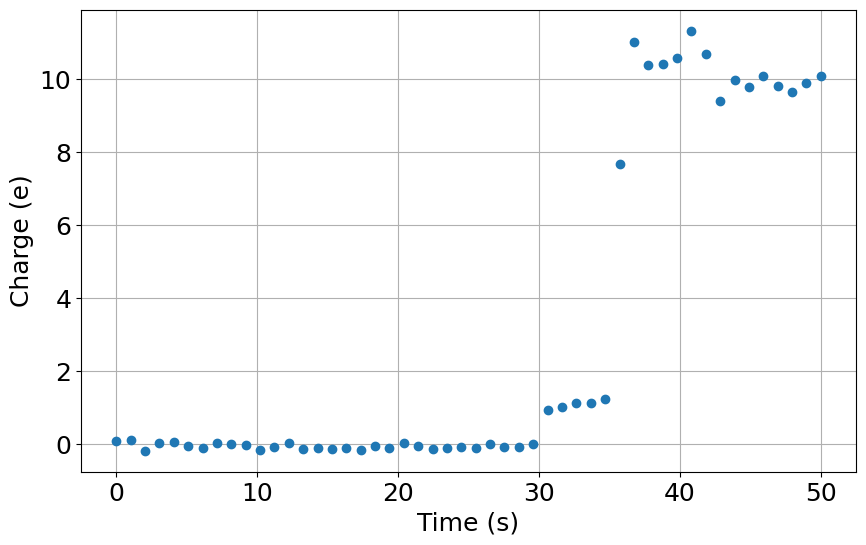

In [110]:
time = np.linspace(0, 50, 50)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
plt.ylim(0, 1*10**(-8))
plt.show()

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, (np.array(sig)- 3.5*10**(-9))/(4*10**(-9)), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Charge (e)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 13

In [85]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 13\\Charging.mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

In [86]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*1*10**6:(i+1)*1*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

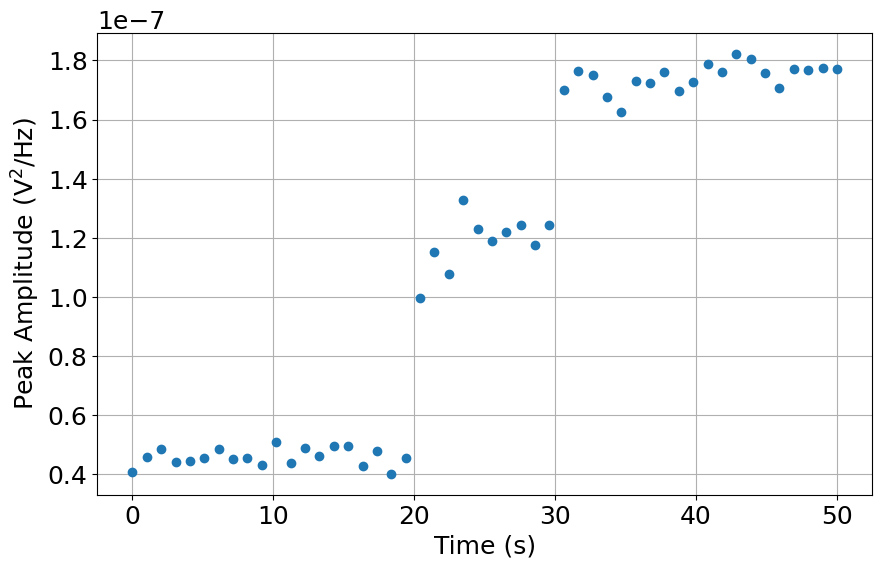

In [87]:
time = np.linspace(0, 50, 50)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 14

In [100]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 14\\Charging.mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

In [101]:
PSDlist = []
sig = []
for i in range(100):
    PSDtmp = scisig.welch(signal1[i*5*10**5:(i+1)*5*10**5], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

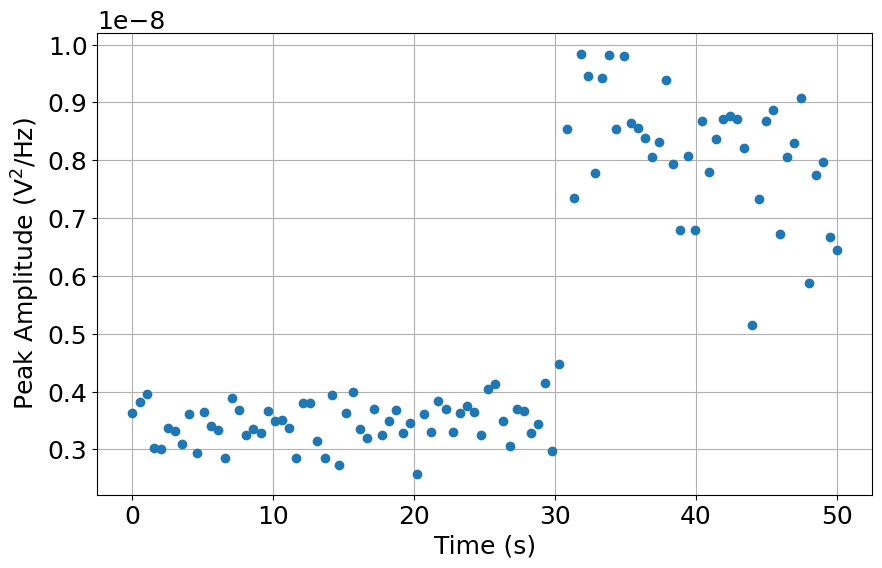

In [102]:
time = np.linspace(0, 50, 100)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 15

In [111]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 15\\Charging.mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

In [112]:
PSDlist = []
sig = []
for i in range(100):
    PSDtmp = scisig.welch(signal1[i*5*10**5:(i+1)*5*10**5], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

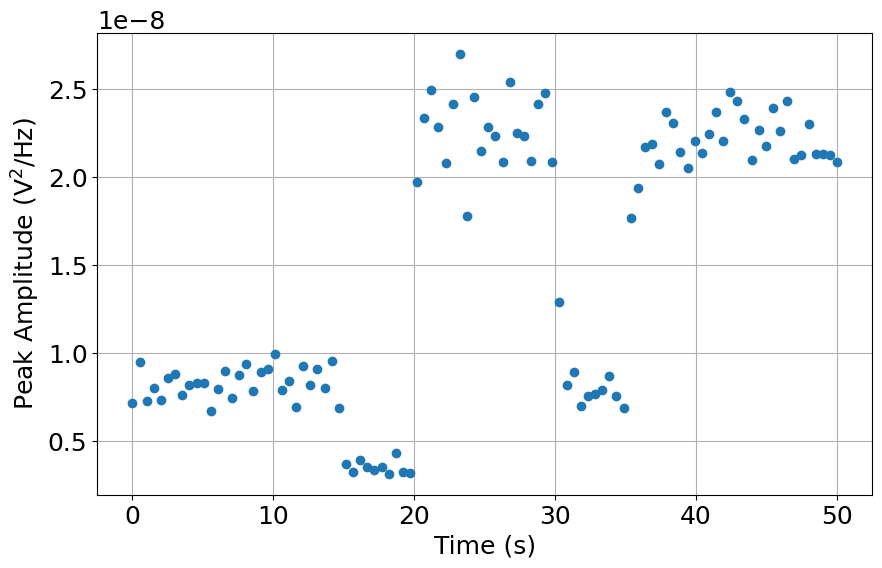

In [113]:
time = np.linspace(0, 50, 100)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

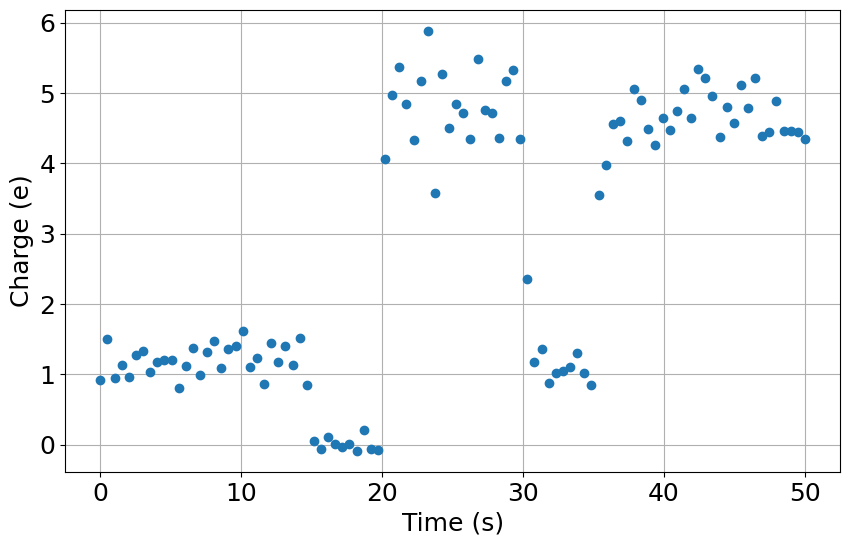

In [114]:
plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, (np.array(sig)- 3.5*10**(-9))/(4*10**(-9)), 'o')
#plt.plot([25, 25], [0, 9*10**(-8)], '--')
#plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Charge (e)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

# Attempt 16

In [115]:
data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 16\\Charging (1).mat')
signal1 = np.transpose(data['B'])[0]
signal2 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 16\\Charging (2).mat')
signal3 = np.transpose(data['B'])[0]
signal4 = np.transpose(data['D'])[0]

data = sio.loadmat('C:\\Users\\Tom\\Documents\\Yale\\data\\Nanosphere\\230118\\Attempt 16\\Charging (3).mat')
signal5 = np.transpose(data['B'])[0]
signal6 = np.transpose(data['D'])[0]

In [116]:
PSDlist = []
sig = []
for i in range(50):
    PSDtmp = scisig.welch(signal1[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal3[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])
    
for i in range(50):
    PSDtmp = scisig.welch(signal5[i*10**6:(i+1)*10**6], fs = 10**6, nperseg = 10**4)
    PSDlist.append(PSDtmp[1])
    sig.append(PSDtmp[1][420])

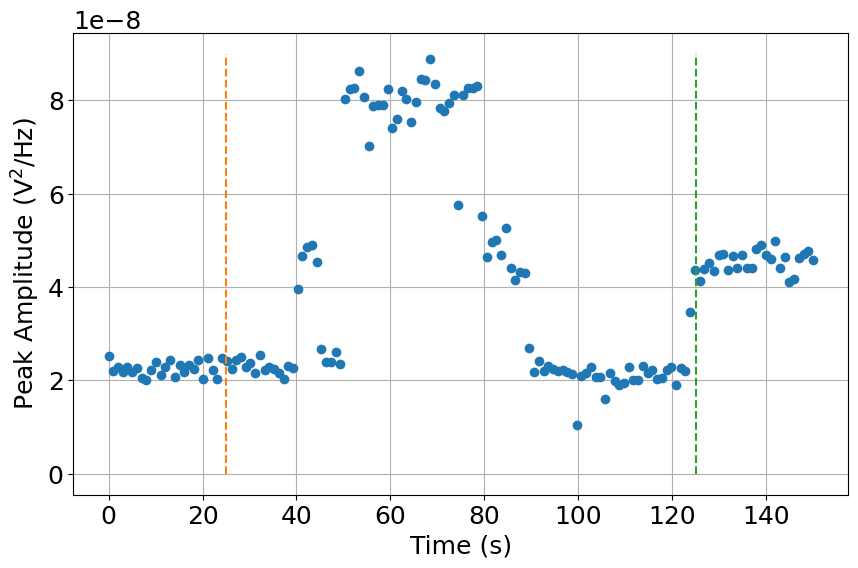

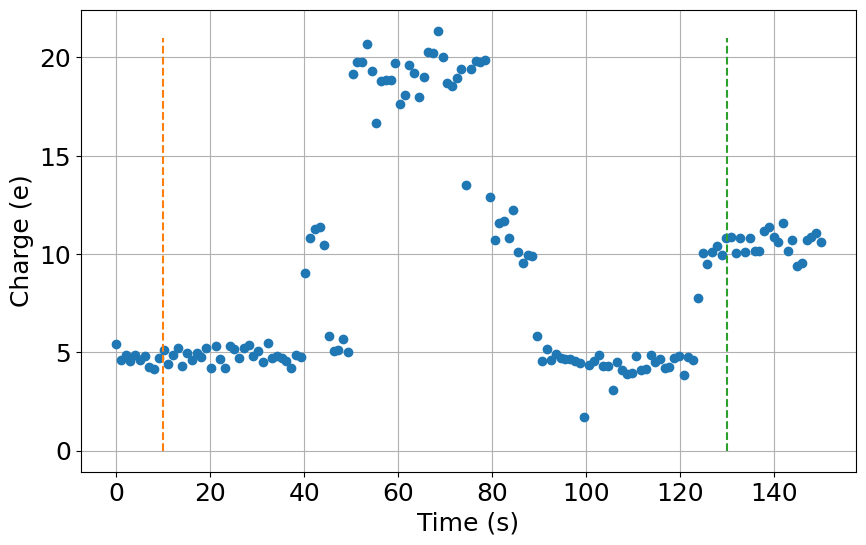

In [120]:
time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, np.array(sig), 'o')
plt.plot([25, 25], [0, 9*10**(-8)], '--')
plt.plot([125, 125], [0, 9*10**(-8)], '--')
plt.ylabel('Peak Amplitude (V$^2$/Hz)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()

time = np.linspace(0, 150, 150)

plt.rc('font', size = 18)
plt.figure(figsize = (10, 6))
plt.grid()
plt.plot(time, (np.array(sig)- 3.5*10**(-9))/(4*10**(-9)), 'o')
plt.plot([10, 10], [0, 21], '--')
plt.plot([130, 130], [0, 21], '--')
plt.ylabel('Charge (e)')
plt.xlabel('Time (s)')
#plt.ylim(0, 2*10**(-8))
plt.show()